<center>
    
# Forest Cover Type Prediction

    Spring 2019 
    
</center>

![alt text](images/forest.png "Forest Cover")

## Introduction
Can we predict the type of tree cover given cartographic data such as elevation, hydrologic, sunlight and soil data? 
This project attempts to predict the predominant type of tree in sections of wooded areas. 

Understanding forest composition is a valuable aspect of managing the health and vitality of our wilderness
areas. Classifying cover type can help further research regarding forest fire susceptibility and de/re-forestation concerns. 

The data used in this report was taken from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php). The data set consists of 15,120 samples 
of 30m x 30m patches of forest located in northern Colorado’s Roosevelt National Forest. . These areas represent forests with minimal
human-caused disturbances, so forest covers are more a result of ecological processes than forest management
practices. 


The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. We are asked to predict an integer classification for the forest cover type. The seven types are:  

$\hspace{10mm}$   1. Spruce/Fir  
$\hspace{10mm}$   2. Lodgepole Pine  
$\hspace{10mm}$   3. Ponderosa Pine  
$\hspace{10mm}$   4. Cottonwood/Willow  
$\hspace{10mm}$   5. Aspen  
$\hspace{10mm}$   6. Douglas-fir  
$\hspace{10mm}$   7. Krummholz  

The training set (15120 observations) contains both features and the Cover_Type.   

### Data Fields 

Name | Unit of Measurement | Description
---|---|-----
Elevation | meters | Elevation
Aspect|degrees azimuth | Aspect
Slope | degrees | Slope
Horizontal_Distance_To_Hydrology | meters |Horz Dist to nearest surface water features
Vertical_Distance_To_Hydrology | meters |Vert Dist to nearest surface water features
Horizontal_Distance_To_Roadways | meters |Horz Dist to nearest roadway
Hillshade_9am | (0 to 255 index) | Hillshade index at 9am, summer solstice
Hillshade_Noon | (0 to 255 index) | Hillshade index at noon, summer solstice
Hillshade_3pm | (0 to 255 index) | Hillshade index at 3pm, summer solstice
Horizontal_Distance_To_Fire_Points | meters |Horz Dist to nearest wildfire ignition points
Wilderness_Area |(4 binary columns, 0 = absence or 1 = presence) | Wilderness area designation
Soil_Type |(40 binary columns, 0 = absence or 1 = presence) | Soil Type designation
Cover_Type |(7 types, integers 1 to 7) | Forest Cover Type designation

## Understanding the dependencies in the features

Hillshade at time t varies as a factor of:
cos(slope)cos(90−Altitude)+sin(slope)sin(90−Altitude)cos(Azimuth−Aspect)
where Altitude is the angle of the Sun relative to the horizon and Azimuth relates to the direction the Sun is facing:
North, South, East, or West. Azimuth of 90 degrees corresponds to East.

This equation actually arises from a theorem in Spherical geometry known as “Spherical law of Cosines” relating the sides 
and angles of triangles constructed on spherical surfaces.

In a unit sphere, lengths a, b, c correspond to the angle subtended by those sides from the center of the sphere. 
If we know the two sides a, b and the angle between them C, then the cosine of c, is given by:

> In short, the Illumination of the patch(Hillshade) is related to alitude of the sun, slope of the terrain and 
the aspect.More details can be found in [How Hillshade works](http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-hillshade-works.htm).We might have features like Aspect, Slope and HillShade that provides similar information.

<img src="images/Variables.png" alt="Approch" style="height: 300px;width: 300px;"/>

The azimuth is the angular direction of the sun, measured from north in clockwise degrees from 0 to 360. An azimuth of 90 degrees is east. The default azimuth is 315 degrees (NW).

The altitude is the slope or angle of the illumination source above the horizon. The units are in degrees, from 0 (on the horizon) to 90 (overhead). The default is 45 degrees.

<img src="images/Altitude.gif" alt="Approch" style="height: 100px;width: 200px;"/>

## Modeling Approach
Here is the overview of our approach in finding the forest covers.
<img src="images/FlowDiagramForest1.png" alt="Approch" style="height: 700px;width: 600px;"/>

## Fetch the dataset

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, GradientBoostingClassifier,AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics
import seaborn as sns
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')


In [2]:
# import the neural network modules
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, Conv1D, Conv2D, Flatten, MaxPool2D
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [3]:
df = pd.read_csv('data/train.csv', engine='c')
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


## Initial Data Analysis

First, we are interested to know if there are any missing values in the data, the data types of the features, and whether or not the labels have a balanced distribution.

#### Determine Shape and Size

In [4]:
#Check the shape and Size of the data
df.shape

(15120, 56)

In [5]:
#All columns are Integer
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

#### Determine Missing Values

In [6]:
# No missing values
df[df.isnull().any(axis=1)]

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type


#### Change the index to Id

In [7]:
#Setting the Id as index might help in fetching data easier
df.set_index('Id',inplace=True)

#### Check if there is a bias on the labels

In [8]:
df["Cover_Type"].value_counts()
## No bias . All have equal records

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

**Here are our high level observations:**
* There are total 15120 records in the training set with 55 independent features.
* There are no missing values in the dataset.
* The kaggle training data was not a simple random sample of the entire dataset,but a stratified sample of the seven forest classes. The training data was equally distributed among the seven classes. 
* All the fields are of integer data-type.

## Split the Dataset into train and validation

We split the data into test and validation sets before doing further exploratory data analysis.  Exploratory data Analysis will be done on the training set.

In [9]:
#Now split the data randomly into train and validation set 
X=df.drop(['Cover_Type'], axis = 1)
y = df['Cover_Type']
X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.20, random_state=42,stratify=y)
print("The shape of validation data:{} and {} ".format(X_val.shape,y_val.shape))
print("The shape of training data:{} and {} ".format(X_train.shape,y_train.shape))
# Added the label temporariliy for EDA
X_train['Cover_Type']=y_train



The shape of validation data:(3024, 54) and (3024,) 
The shape of training data:(12096, 54) and (12096,) 


## Exploratory Data Analysis

### Plot data 
**A. Boxplots distribution for the continuous fatures.**   This will give us an idea of the outliers if any.


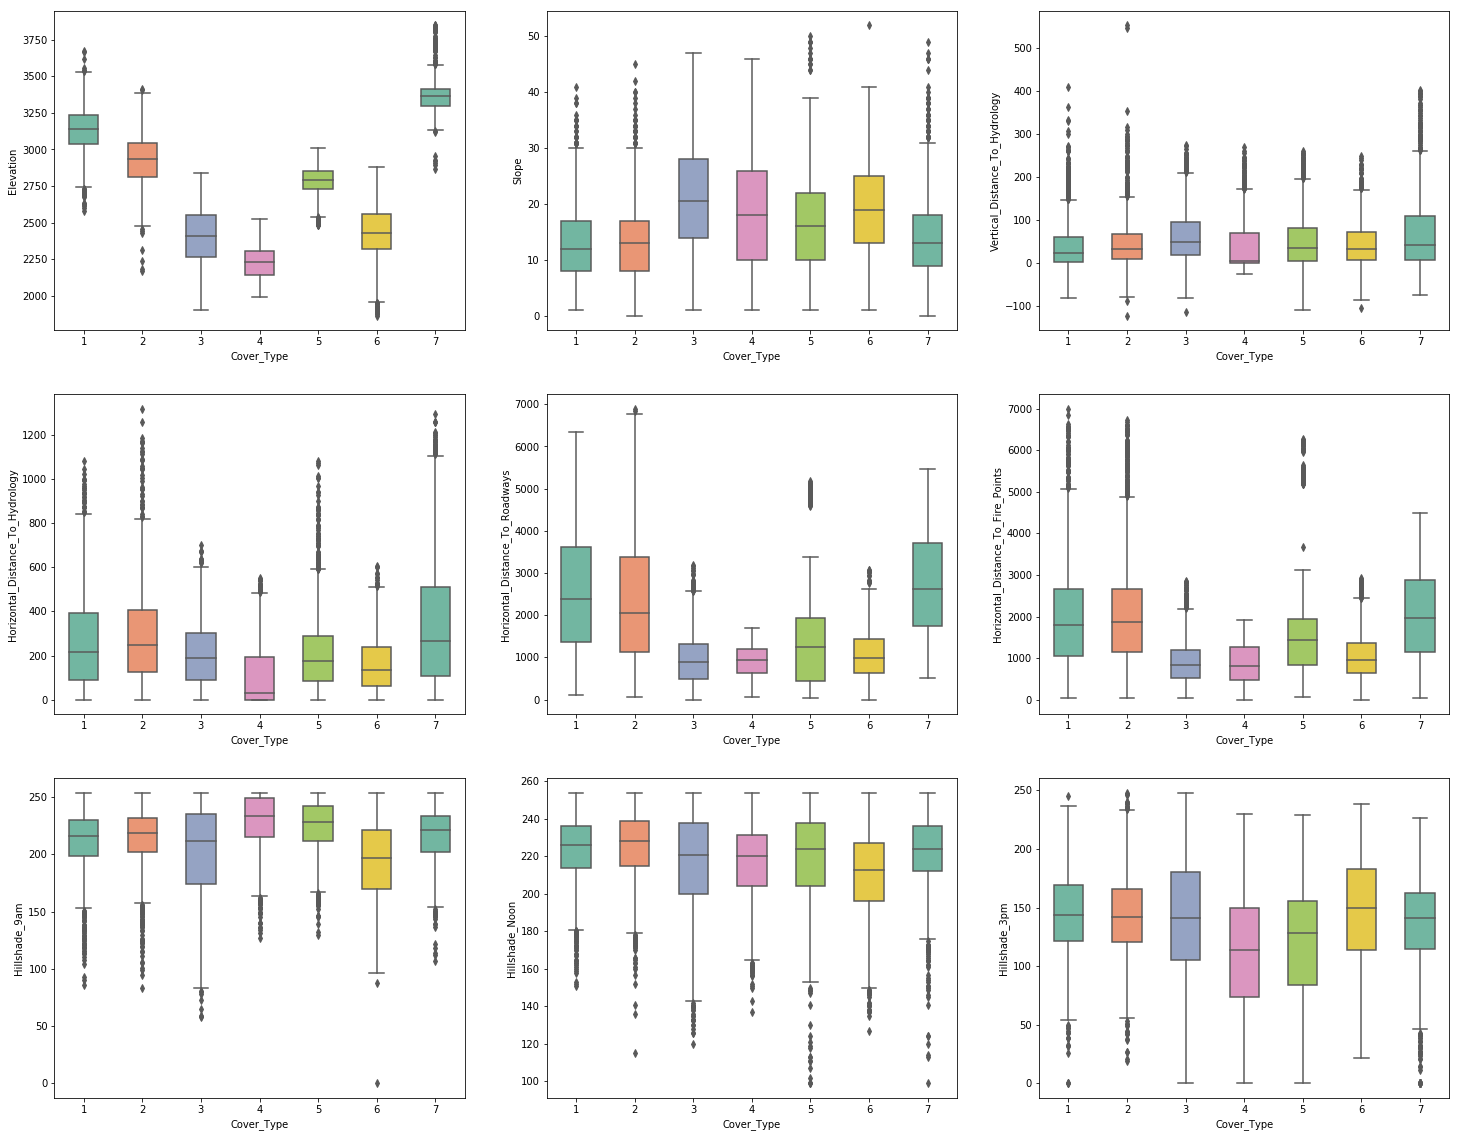

In [10]:
cmap = sns.color_palette("Set2")

def boxPlot(first_feature, sec_feature):
    sns.boxplot(x=first_feature, y=sec_feature, data=X_train, palette=cmap, width=0.5);

f = plt.figure(figsize=(25,20))
f.add_subplot(331)
boxPlot('Cover_Type','Elevation')
f.add_subplot(332)
boxPlot('Cover_Type','Slope')
f.add_subplot(333)
boxPlot('Cover_Type','Vertical_Distance_To_Hydrology')
f.add_subplot(334)
boxPlot('Cover_Type','Horizontal_Distance_To_Hydrology')
f.add_subplot(335)
boxPlot('Cover_Type','Horizontal_Distance_To_Roadways')
f.add_subplot(336)
boxPlot('Cover_Type','Horizontal_Distance_To_Fire_Points')
f.add_subplot(337)
boxPlot('Cover_Type','Hillshade_9am')
f.add_subplot(338)
boxPlot('Cover_Type','Hillshade_Noon')
f.add_subplot(339)
boxPlot('Cover_Type','Hillshade_3pm')


>Looking at the data distribution in the context of class seperation, elevation could be the most significant factor in determining cover type. Also, apart from elevation the rest of the features are almost similarly distributed between CoverType1 and CoverType2.


**B. Histogram distribution of continuous features**
Let's look at the underlying data distribution of each column and see if they follow a normal distribution. Based on that, we will decide whether to identify outliers by z-score or by IQR.

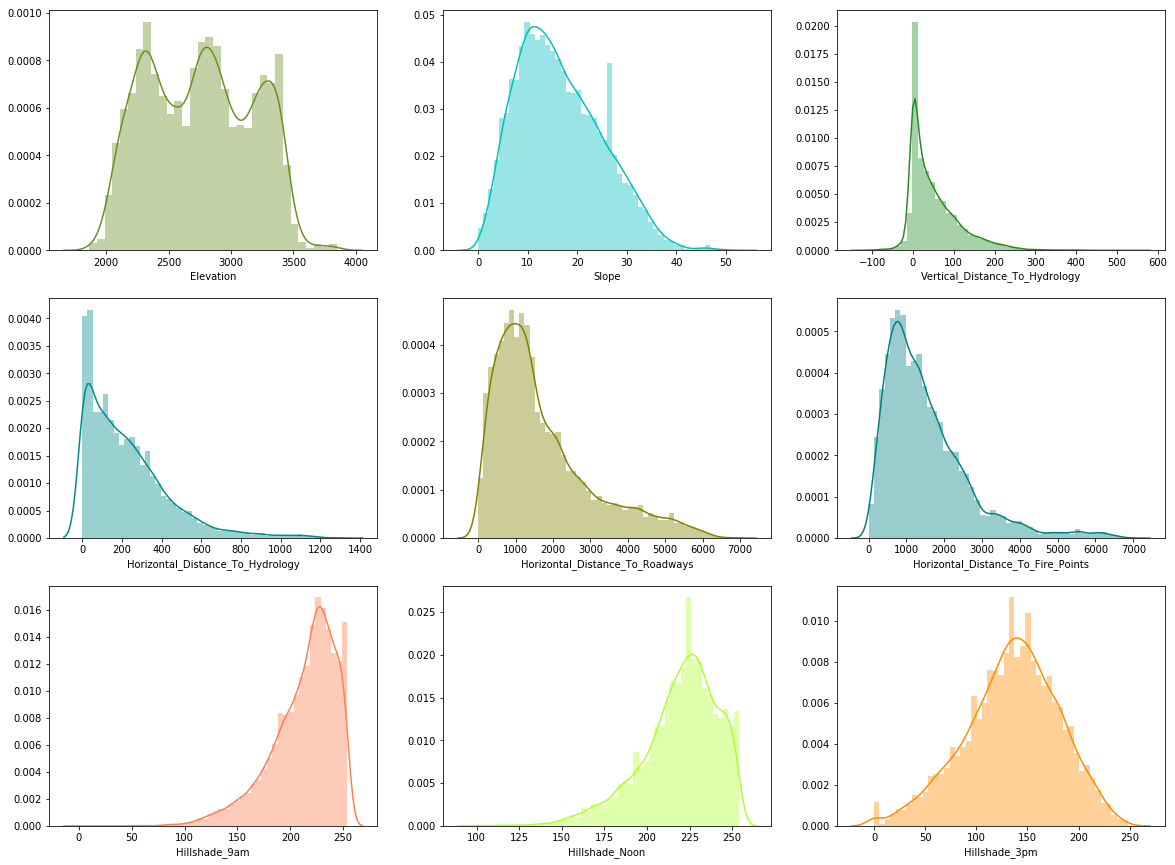

In [11]:
def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col);

f = plt.figure(figsize=(20,15))
f.add_subplot(331)
histPlot(X_train['Elevation'],'olivedrab')
f.add_subplot(332)
histPlot(X_train['Slope'],'c')
f.add_subplot(333)
histPlot(X_train['Vertical_Distance_To_Hydrology'],'forestgreen')
f.add_subplot(334)
histPlot(X_train['Horizontal_Distance_To_Hydrology'],'darkcyan')
f.add_subplot(335)
histPlot(X_train['Horizontal_Distance_To_Roadways'],'olive')
f.add_subplot(336)
histPlot(X_train['Horizontal_Distance_To_Fire_Points'],'teal')
f.add_subplot(337)
histPlot(X_train['Hillshade_9am'],'coral')
f.add_subplot(338)
histPlot(X_train['Hillshade_Noon'],'greenyellow')
f.add_subplot(339)
histPlot(X_train['Hillshade_3pm'],'darkorange')

### Finding Outliers
>Since not all the features follow a normal distribution, we will use the IQR to find outliers. We are using 3 times the IQR for each feature to identify the outliers.

In [12]:
#Find outliers
from numpy import percentile
import itertools
def findCutOff(feature):
    #print(feature.index[feature>20])
    q25, q75 = percentile(feature, 25), percentile(feature, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 3
    lower, upper = q25 - cut_off, q75 + cut_off
    #return lower, upper
    return feature.index[(feature<lower)|(feature>upper)].tolist()


all_outliers=[]
#outliers
slope= X_train.groupby('Cover_Type')['Slope'].agg(findCutOff)
merged_slope = list(itertools.chain.from_iterable(slope))
all_outliers.append(merged_slope)
#Vertical_Distance_To_Hydrology
vh=X_train.groupby('Cover_Type')['Vertical_Distance_To_Hydrology'].agg(findCutOff)
merged_vh = list(itertools.chain.from_iterable(vh))
all_outliers.append(merged_vh)

#Horizontal_Distance_To_Hydrology
hh=(X_train.groupby('Cover_Type')['Horizontal_Distance_To_Hydrology'].agg(findCutOff))
merged_hh = list(itertools.chain.from_iterable(hh))
all_outliers.append(merged_hh)

#Horizontal_Distance_To_Roadways
hr=(X_train.groupby('Cover_Type')['Horizontal_Distance_To_Roadways'].agg(findCutOff))
merged_hr = list(itertools.chain.from_iterable(hr))
all_outliers.append(merged_hr)

#Horizontal_Distance_To_Fire_Points
hf=X_train.groupby('Cover_Type')['Horizontal_Distance_To_Fire_Points'].agg(findCutOff)
merged_hf = list(itertools.chain.from_iterable(hf))
all_outliers.append(merged_hf)

#Hillshade_9am
h9=(X_train.groupby('Cover_Type')['Hillshade_9am'].agg(findCutOff))
merged_h9 = list(itertools.chain.from_iterable(h9))
all_outliers.append(merged_h9)

#Hillshade_Noon
hn=(X_train.groupby('Cover_Type')['Hillshade_Noon'].agg(findCutOff))
merged_hn = list(itertools.chain.from_iterable(hn))
all_outliers.append(merged_hn)

#Hillshade_Noon
h3=(X_train.groupby('Cover_Type')['Hillshade_3pm'].agg(findCutOff))
merged_h3 = list(itertools.chain.from_iterable(h3))
all_outliers.append(merged_h3)
all_outliers = list(itertools.chain.from_iterable(all_outliers))
print("Total number of outliers: ",len(all_outliers))
print("Total number of outliers by cover type: ")
unique_index=np.unique(all_outliers)

X_train.loc[unique_index,:].Cover_Type.value_counts()
#X_train.loc[unique_index,:][X_train.Cover_Type==5].iloc[:,df.columns.str.startswith('Soil')].sum()


Total number of outliers:  144
Total number of outliers by cover type: 


5    74
2    32
1    21
7     6
6     1
Name: Cover_Type, dtype: int64

#### Observations of outliers
There are total of 144 outliers
1. Most of the Outliers are in Wilderness_Area1, some are in Wilderness_Area3
2. Outliers are found in Soil_Type18, Soil_Type29, and Soil_Type30
3. Most of the outliers are from Cover_Types 5, 2, and 1. There are 6 records of Cover_Type=7 and one record of Cover_Type=6
4. We remove the outliers before modelling under the assumption that their removal will improve model performance.

### Removing Outliers
Before doing the modeling we removed the outliers

In [13]:
# Let's see if deleting the outliers helps or not
X_train.drop(unique_index,axis='rows',inplace=True)
y_train.drop(unique_index,axis='rows',inplace=True)
y_train.shape

(11962,)

**C. Scatterplots, comparsion among the independent variable.**  
**Aspect vs. Hillshade** Aspect is the orientation of slope, measured clockwise in degrees from 0 to 360, where 0 is north-facing, 90 is east-facing, 180 is south-facing, and 270 is west-facing. Let's look at aspect vs Hillshade .

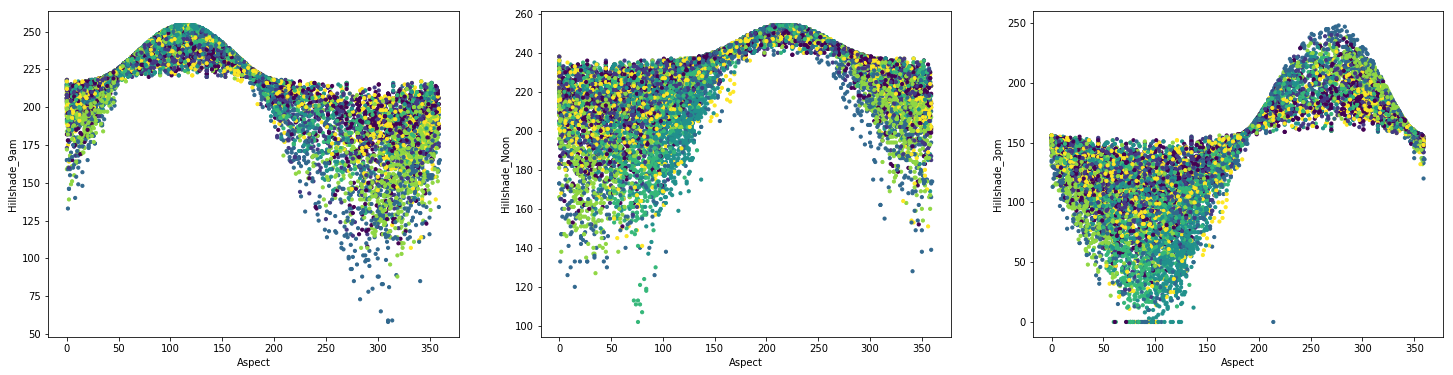

In [14]:

classes = np.array(list(X_train.Cover_Type.values))

def plotRelation(first_feature, sec_feature,cmap='viridis'):
    plt.scatter(first_feature, sec_feature, c = classes, s=10,cmap=cmap)
    plt.xlabel(first_feature.name)
    plt.ylabel(sec_feature.name)
    
f = plt.figure(figsize=(25,6))
f.add_subplot(131)
plotRelation( X_train.Aspect,X_train.Hillshade_9am)
f.add_subplot(132)
plotRelation(X_train.Aspect,X_train.Hillshade_Noon)
f.add_subplot(133)
plotRelation(X_train.Aspect,X_train.Hillshade_3pm)


255 is brightest light for hillshade and it is directly correlated to Aspect direction. Maybe these two variables can be merged to one with some equtaion.  

>There is 1 record of Hillshade_9am with a zero value and around 70 records of Hillshade_3pm with zero values. But as per the [calculation of Hillshade](http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-hillshade-works.htm), 0 values are appropriate. Hence we kept the values as is.

#### D. Slope vs Hillshade

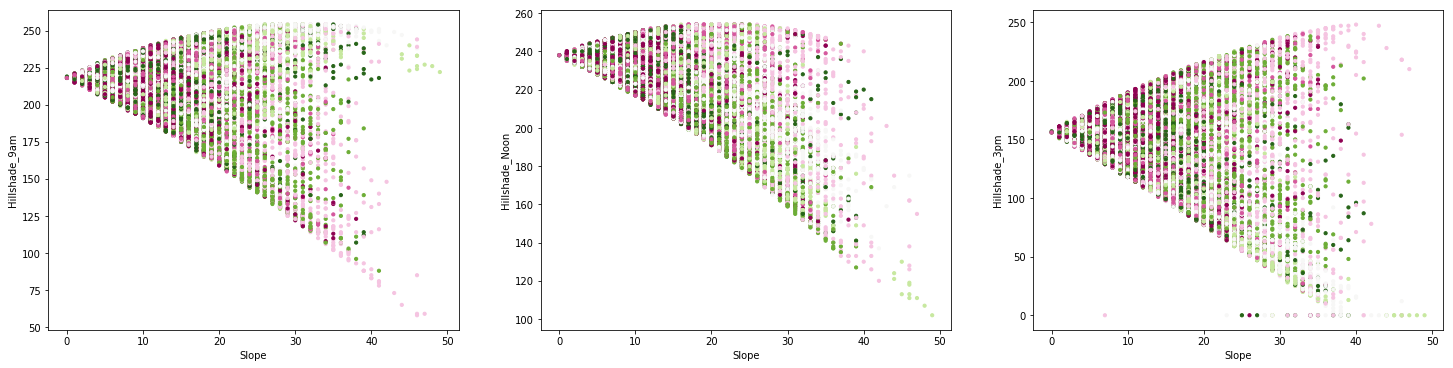

In [15]:
f = plt.figure(figsize=(25,20))
f.add_subplot(331)
plotRelation( X_train.Slope,X_train.Hillshade_9am,cmap='PiYG')
f.add_subplot(332)
plotRelation(X_train.Slope,X_train.Hillshade_Noon,cmap='PiYG')
f.add_subplot(333)
plotRelation(X_train.Slope,X_train.Hillshade_3pm,cmap='PiYG')


#### E. Relationship between elevation and distance to everything**  


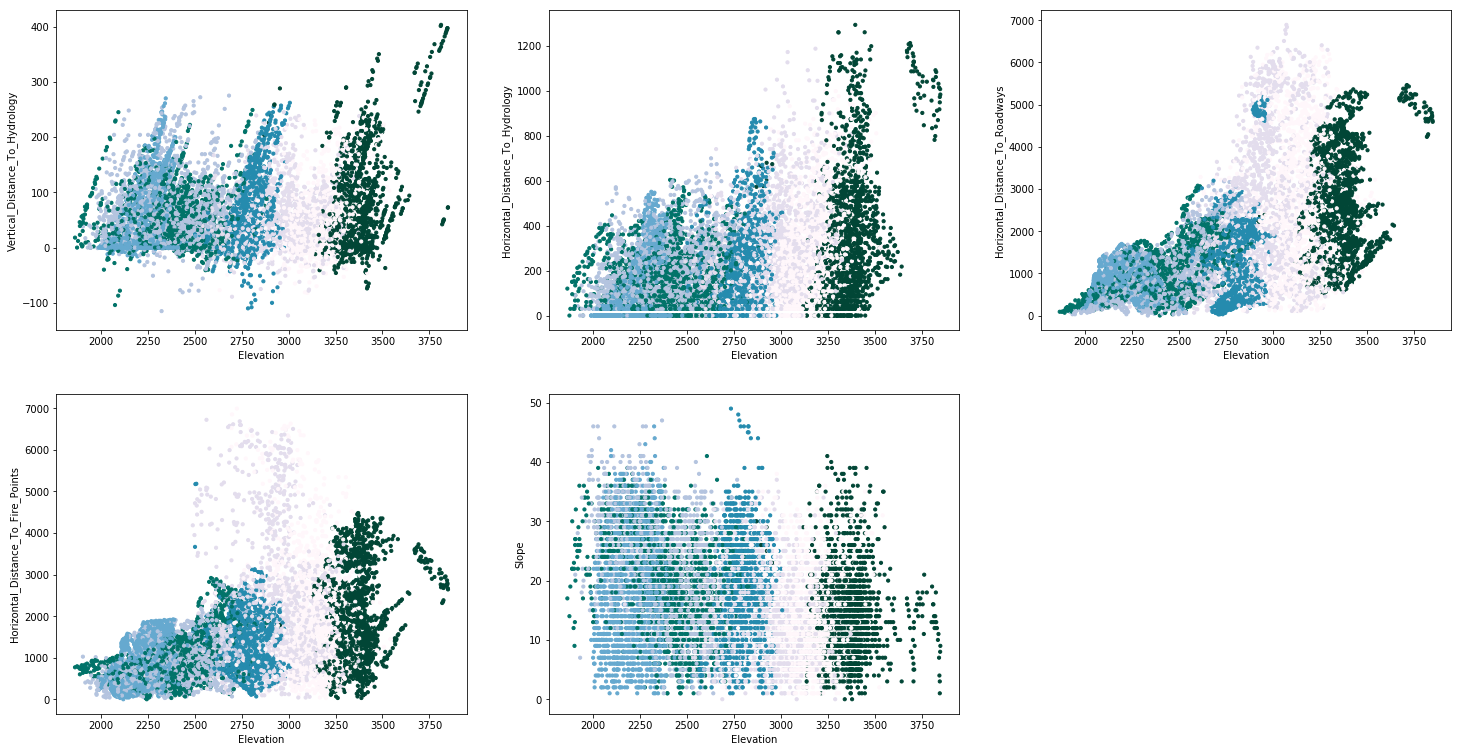

In [16]:
f = plt.figure(figsize=(25,20))
f.add_subplot(331)
plotRelation( X_train.Elevation,X_train.Vertical_Distance_To_Hydrology,cmap='PuBuGn')
f.add_subplot(332)
plotRelation(X_train.Elevation,X_train.Horizontal_Distance_To_Hydrology,cmap='PuBuGn')
f.add_subplot(333)
plotRelation(X_train.Elevation,X_train.Horizontal_Distance_To_Roadways,cmap='PuBuGn')
f.add_subplot(334)
plotRelation(X_train.Elevation,X_train.Horizontal_Distance_To_Fire_Points,cmap='PuBuGn')
f.add_subplot(335)
plotRelation(X_train.Elevation,X_train.Slope,cmap='PuBuGn')



#### F. Soil type
Let's look at the distribution of the soil type. There are 40 soli types in the dataset.

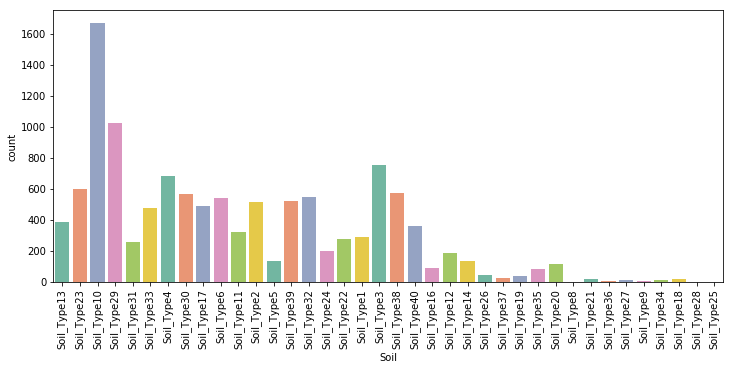

In [17]:
soil_dummies = X_train.loc[:,X_train.columns.str.startswith('Soil_Type')]
#wild = wild_dummies.idxmax(axis=1)
soil = soil_dummies.idxmax(axis=1)
#wild.name = 'Wilderness'
soil.name = 'Soil'
X_train['Soil'] = soil
plt.figure(figsize=(12,5))
sns.countplot(x='Soil',data=X_train,palette=cmap);
plt.xticks(rotation=90);

>Soil types 7 and 15 do have any records.  Hence they can be deleted.

Also, we think it may be appropriate to merge the soil types into smaller buckets based on broader soil characteristics.  

* Stony - 1-2, 6,9,12,18,24-34, 36-40  
* Rubly - 3,4,5,10,11,13  
* Other - 7,8,14-17,19,20,21,22,,23  

In [18]:
X_train.drop(['Soil_Type7','Soil_Type15'],axis='columns',inplace=True)
X_val.drop(['Soil_Type7','Soil_Type15'],axis='columns',inplace=True)


#### G. Vertical distance to hydrology 
Some of the variables are negative. Since we believe vertical distance should not be negative, we convert the vertical distances to absolute value.

In [19]:
X_train['Vertical_Distance_To_Hydrology'] = abs(X_train['Vertical_Distance_To_Hydrology'] )
X_val['Vertical_Distance_To_Hydrology'] = abs(X_val['Vertical_Distance_To_Hydrology'] )

#### H. Correlation Heat Map
We do observe a strong correlation between hillshade and aspect as described in the section "Understanding the Feature Dependencies" above. 

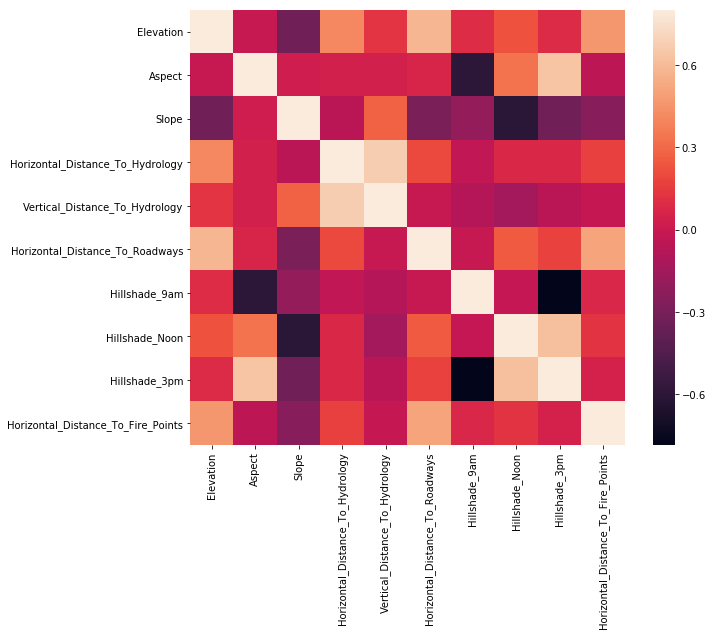

In [20]:
#Defining the number of features for the Correlation Heat Map
size = 10
corrmat = X_train.iloc[:,:size].corr()
f, ax = plt.subplots(figsize = (10,8))
sns.heatmap(corrmat,vmax=0.8,square=True);

#### H. Correlation Values
We do observe some strong correlations as folllows: 

$\hspace{10mm}$   1. Aspect is highly correlated to Hillshade_9am and Hillshade_3pm

$\hspace{10mm}$   2. Horizontal distance to hydrology is highly correlated to Vertical Distance to Hydrology

$\hspace{10mm}$   3. Slope and Hillshade_Noon

$\hspace{10mm}$   4. Elevation and Horizontal Distance to Roadways 

Our hypothesis is that the feature selection process later inn this notebook will allow us to determine which of the highly correlated features should be dropped from our feature set, if any.

In [21]:
data = X_train.iloc[:,:size]

# Get name of the columns
cols = data.columns

# Calculate the pearson correlation coefficients for all combinations
data_corr = data.corr()
print(data_corr)

                                    Elevation    Aspect     Slope  \
Elevation                            1.000000 -0.009200 -0.322866   
Aspect                              -0.009200  1.000000  0.021589   
Slope                               -0.322866  0.021589  1.000000   
Horizontal_Distance_To_Hydrology     0.407018  0.042554 -0.056419   
Vertical_Distance_To_Hydrology       0.127989  0.044631  0.278980   
Horizontal_Distance_To_Roadways      0.582442  0.064460 -0.286204   
Hillshade_9am                        0.100019 -0.592402 -0.195054   
Hillshade_Noon                       0.226805  0.333081 -0.606347   
Hillshade_3pm                        0.094159  0.636480 -0.325894   
Horizontal_Distance_To_Fire_Points   0.462559 -0.044996 -0.240623   

                                    Horizontal_Distance_To_Hydrology  \
Elevation                                                   0.407018   
Aspect                                                      0.042554   
Slope                   

## Feature Scaling

#### Note : We only scale numeric values.  Dummy variables are untouched.

In [22]:
X_train.drop(['Cover_Type','Soil'], axis = 1,inplace=True)
X_train_orig=X_train.copy()
y_train_orig = y_train.copy()
X_val_orig = X_val.copy()
y_val_orig = y_val.copy()

In [23]:
# Scale to mean = 0, sd = 1
scaler = preprocessing.StandardScaler()
scaledColsOrig=['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
            'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
            'Horizontal_Distance_To_Fire_Points']

X_train_orig[scaledColsOrig] = scaler.fit_transform(X_train_orig[scaledColsOrig])
X_val_orig[scaledColsOrig] = scaler.transform(X_val_orig[scaledColsOrig])


## Run Baseline Model
1. For the original data provided, we will run the following models as baselines
    * KNN
    * Neural Network

    


### 1. KNN Classification on the Original dataset

In [24]:
#Run KNN with only the Original data provided
k_range=[1,5,10,15,20,25,30,35,40]#range(1,30)
scores1=[]
for k in k_range:
    knn1=KNeighborsClassifier(n_neighbors=k)
    knn1.fit(X_train_orig, y_train_orig)
    y_predict1 =  knn1.predict(X_val_orig)
    scores1.append(metrics.accuracy_score(y_val_orig,y_predict1))
    

0.7992724867724867

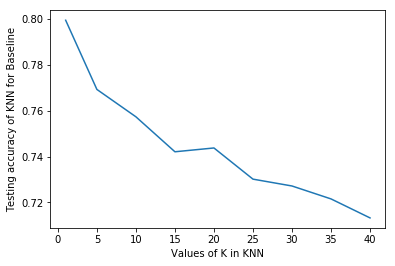

In [25]:
#Plot KNN with only the Original data provided
plt.plot(k_range,scores1)
plt.xlabel("Values of K in KNN")
plt.ylabel("Testing accuracy of KNN for Baseline")
max(scores1)

In [26]:
#Let's check how much of labels are predicted correctly
#Run the KNN with k=1 
knn_orig=KNeighborsClassifier(n_neighbors=1)
knn_orig.fit(X_train_orig, y_train_orig)
y_predict_knn =  knn_orig.predict(X_val_orig)
metrics.confusion_matrix(y_val_orig,y_predict_knn)


array([[287,  93,   1,   1,  18,   1,  31],
       [ 87, 261,  11,   2,  44,  19,   8],
       [  0,   5, 301,  28,  12,  86,   0],
       [  0,   0,  16, 400,   0,  16,   0],
       [  5,  16,   9,   0, 399,   3,   0],
       [  1,  11,  50,   9,   7, 354,   0],
       [ 16,   1,   0,   0,   0,   0, 415]], dtype=int64)

In [27]:
target_names = ['CT 1', 'CT 2', 'CT 3','CT 4','CT 5','CT 6','CT 7']
labels=[1,2,3,4,5,6,7]
knnReport= metrics.classification_report(y_val_orig, y_predict_knn,target_names=target_names,
                                         labels=labels)
print(knnReport)

              precision    recall  f1-score   support

        CT 1       0.72      0.66      0.69       432
        CT 2       0.67      0.60      0.64       432
        CT 3       0.78      0.70      0.73       432
        CT 4       0.91      0.93      0.92       432
        CT 5       0.83      0.92      0.88       432
        CT 6       0.74      0.82      0.78       432
        CT 7       0.91      0.96      0.94       432

   micro avg       0.80      0.80      0.80      3024
   macro avg       0.80      0.80      0.80      3024
weighted avg       0.80      0.80      0.80      3024



### Observation from KNN
1. k=1 provides the best accuracy score. One reason for may be that the the data are fairly dense, at least for the non-dummy variable features.  This makes it more likley that a close training data point can be found with a small k value.  
2. The classifier has a hard time predicting cover types 1,2 and 3. Recall score is bad for 1,2,3.  It is uclear what is causing the poorer performance for those classes. 
3. As seen from the confusion matrix, most wrong classifications are between Cover Type 1 and COver Type 2 and between 3 and 6. 
4. Removing the outliers has not significantly improvemed the accuracy of the model (tests with outliers included not shown in this notebook.)

### Create baseline KNN submission for Kaggle



In [73]:
# Read in the test data
kaggle_df = pd.read_csv('data/test.csv', engine='c')
kaggle_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,...,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,...,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,...,0,0,0,0,0,0,0,0,0,0
3,15124,2709,24,17,0,0,2950,208,201,125,...,0,0,0,0,0,0,0,0,0,0
4,15125,2706,29,19,0,0,2920,210,195,115,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Doing the same data prep steps here as were done to the training data
# check for missing values in the test data -- none found
kaggle_df[kaggle_df.isnull().any(axis=1)]
# Setting the Id as index 
kaggle_df.set_index('Id',inplace=True)

# drop soil types that were dropped due to no values for them in the training data
kaggle_df.drop(['Soil_Type7','Soil_Type15'],axis='columns',inplace=True)

# use the absolute value for any Vertical Distance to Hydrology values that are negative
# just like we did on our training data
kaggle_df['Vertical_Distance_To_Hydrology'] = abs(kaggle_df['Vertical_Distance_To_Hydrology'])

# Scale the continuous data as we did with the training data
scaler = preprocessing.StandardScaler()

# scaledColsOrig columns are defined earlier when we scale the training data 

# Thinking fit_transform is appropriate here, instead of using the fit done earlier on the training
# data, since we have several more observations of test data, and their ranges may be different enough
# to require a separate fit here
kaggle_df[scaledColsOrig] = scaler.fit_transform(kaggle_df[scaledColsOrig])


In [ ]:
# Use knn_orig model created above (k=1)

kaggle_predict_knn_baseline =  knn_orig.predict(kaggle_df)
kaggle_predict_knn_baseline.shape

In [ ]:
# create the table of IDs and predicted cover types for submission file
kaggle_df.reset_index(inplace=True)

tmp_arr=np.zeros((len(kaggle_predict_knn_baseline),2),dtype=int)
tmp_arr[:,0]=kaggle_df.Id
tmp_arr[:,1]=kaggle_predict_knn_baseline
submit_file = pd.DataFrame({'Id':tmp_arr[:,0],'Cover_Type':tmp_arr[:,1]})
print(submit_file.shape)
submit_file.head()

In [ ]:
# And write out the csv file

sub_file_csv = submit_file.to_csv(index=False)
csvfile = open('baselinesubmit.csv', "w", encoding="utf8")   
csvfile.write(sub_file_csv)
csvfile.close()

### 2. Neural Network on the original dataset

In [28]:
# First binarize the labels per Todd's guidance
def binarizeY(data):
    binarized_data = np.zeros((data.size,7))
    for j in range(0,data.size):
        feature = data[j:j+1]
        i = feature.astype(np.int64) 
        binarized_data[j,i-1]=1 # subtracting 1 here since the index values are 0 = 6 while range of labels is 1 - 7
    return binarized_data
y_train_orig_b = binarizeY(y_train_orig)
y_val_orig_b = binarizeY(y_val_orig)
numClasses = y_train_orig_b[1].size
print ('Classes = %d' %(numClasses))

Classes = 7


In [29]:
# and let's fit a 2 layer NN

model = Sequential() 
# the nodes here were arbitrary
model.add(Dense(30, input_dim=52, activation='relu'))
model.add(Dense(7, input_dim=30, activation='softmax'))

## Cost function & Objective (and solver)
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_orig, y_train_orig_b, shuffle=True, batch_size=10,verbose=0, epochs=50) 
score = model.evaluate(X_val_orig, y_val_orig_b, verbose=0) 
print('loss:', score[0]) 
print('accuracy:', score[1])

nn_pred = model.predict_classes(X_val_orig)
nn_pred = nn_pred + 1 # adding one back to compensate for 1 - 7 labels converted to 0 - 6 index in binarizing function

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
loss: 0.5928830017173101
accuracy: 0.7582671957671958


### Create Kaggle submission for baseline Neural Network model

In [ ]:
# using the data already prepared for the KNN baseline Kaggle submission above, as well as the NN model created above
# kaggle_predict_nn_baseline =  np.argmax(np.round(model.predict(kaggle_df)),axis=1)

# If running this aftern having run the KNN Kaggle submission above, make sure you rerun
# the read of the test data set cell and the Kaggle data prep cell before running this cell

kaggle_predict_nn_baseline =  model.predict_classes(kaggle_df)
kaggle_predict_nn_baseline = kaggle_predict_nn_baseline + 1 # adding one back to compensate for 1 - 7 labels converted to 0 - 6 index in binarizing function
kaggle_predict_nn_baseline.shape

In [ ]:
# create the table of IDs and predicted cover types for submission file
kaggle_df.reset_index(inplace=True)

tmp_arr=np.zeros((len(kaggle_predict_nn_baseline),2),dtype=int)
tmp_arr[:,0]=kaggle_df.Id
tmp_arr[:,1]=kaggle_predict_nn_baseline
submit_file = pd.DataFrame({'Id':tmp_arr[:,0],'Cover_Type':tmp_arr[:,1]})
print(submit_file.shape)
submit_file.head()

In [ ]:
# And write out the csv file

sub_file_csv = submit_file.to_csv(index=False)
csvfile = open('nnbaselinesubmit.csv', "w", encoding="utf8")   
csvfile.write(sub_file_csv)
csvfile.close()

### Plotting Learning Curves

In [30]:
# Function defined in Scikit Learn

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Feature Engineering

* **Climatic zone and Geological zone**:   
Due to relationships between the Soil type attribute with climatic and geological zones, we can extract two extra properties from the data which are not available in the original dataset. These relations are described at [UCI Machine learning repository](https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info). Thus, we will generate 2 new attributes: **Climatic zone and Geological zone**.

    Study Code refers to the soil type:

       Study Code   USFS ELU Code			Description
         1	   2702		Cathedral family - Rock outcrop complex, extremely stony.
         2	   2703		Vanet - Ratake families complex, very stony.
         3	   2704		Haploborolis - Rock outcrop complex, rubbly.
         4	   2705		Ratake family - Rock outcrop complex, rubbly.
         5	   2706		Vanet family - Rock outcrop complex complex, rubbly.
         6	   2717		Vanet - Wetmore families - Rock outcrop complex, stony.
         7	   3501		Gothic family.
         8	   3502		Supervisor - Limber families complex.
         9	   4201		Troutville family, very stony.
        10	   4703		Bullwark - Catamount families - Rock outcrop complex, rubbly.
        11	   4704		Bullwark - Catamount families - Rock land complex, rubbly.
        12	   4744		Legault family - Rock land complex, stony.
        13	   4758		Catamount family - Rock land - Bullwark family complex, rubbly.
        14	   5101		Pachic Argiborolis - Aquolis complex.
        15	   5151		unspecified in the USFS Soil and ELU Survey.
        16	   6101		Cryaquolis - Cryoborolis complex.
        17	   6102		Gateview family - Cryaquolis complex.
        18	   6731		Rogert family, very stony.
        19	   7101		Typic Cryaquolis - Borohemists complex.
        20	   7102		Typic Cryaquepts - Typic Cryaquolls complex.
        21	   7103		Typic Cryaquolls - Leighcan family, till substratum complex.
        22	   7201		Leighcan family, till substratum, extremely bouldery.
        23	   7202		Leighcan family, till substratum - Typic Cryaquolls complex.
        24	   7700		Leighcan family, extremely stony.
        25	   7701		Leighcan family, warm, extremely stony.
        26	   7702		Granile - Catamount families complex, very stony.
        27	   7709		Leighcan family, warm - Rock outcrop complex, extremely stony.
        28	   7710		Leighcan family - Rock outcrop complex, extremely stony.
        29	   7745		Como - Legault families complex, extremely stony.
        30	   7746		Como family - Rock land - Legault family complex, extremely stony.
        31	   7755		Leighcan - Catamount families complex, extremely stony.
        32	   7756		Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
        33	   7757		Leighcan - Catamount families - Rock outcrop complex, extremely stony.
        34	   7790		Cryorthents - Rock land complex, extremely stony.
        35	   8703		Cryumbrepts - Rock outcrop - Cryaquepts complex.
        36	   8707		Bross family - Rock land - Cryumbrepts complex, extremely stony.
        37	   8708		Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
        38	   8771		Leighcan - Moran families - Cryaquolls complex, extremely stony.
        39	   8772		Moran family - Cryorthents - Leighcan family complex, extremely stony.
        40	   8776		Moran family - Cryorthents - Rock land complex, extremely stony.

        Note:   First digit:  climatic zone             Second digit:  geologic zones
                1.  lower montane dry                   1.  alluvium
                2.  lower montane                       2.  glacial
                3.  montane dry                         3.  shale
                4.  montane                             4.  sandstone
                5.  montane dry and montane             5.  mixed sedimentary
                6.  montane and subalpine               6.  unspecified in the USFS ELU Survey
                7.  subalpine                           7.  igneous and metamorphic
                8.  alpine                              8.  volcanic

   The third and fourth ELU digits are unique to the mapping unit and have no special meaning to the climatic or geologic zones.


* **Linear combination :**
     Horizontal dist. to Hydrology may be in the same direction as Fire Points or opposite. Hence, distance between the two can be found either by summing the distance or taking the difference
     * Horizontal dist. to Hydrology, Horizontal dist. to Fire Points 
     * Horizontal dist. to Hydrology, Horizontal dist. to Roadways 
     * Horizontal dist. to Fire Points, Horizontal dist. to Roadways 
* **Euclidean distance**:  
     The euclidean distance is applied to attributes Horizontal distance to Hydrology
    and Vertical distance to Hydrology, generating 1 new attribute.
* **Mean Distance to Amenities :**
     As we know distances to amenities like Water, Fire and Roadways plays a key role in determining cover type
* **Aspect in degrees :**
     We added four new attributes based on Aspect.
    - Aspect_N -> from 315 deg to 45 deg
    - Aspect_E -> from 45 deg to 135 deg
    - Aspect_S -> from 135 deg to 225 deg
    - Aspect_W -> from 225 deg to 315 deg
* **Mean Hillshade:**   
    - Mean hillshade of the hillshade at 9AM, Noon, and 3PM (0-255)
* **Soil Type:**    
    - Stony
    - Rubly 
    - Other

In [31]:
#Climatic Zones
X_train['Clim2'] =X_train.loc[:,X_train.columns.str.contains("^Soil_Type[23456]$")].max(axis=1)
X_train['Clim3'] =X_train.loc[:,X_train.columns.str.contains("^Soil_Type[78]$")].max(axis=1)
X_train['Clim4'] =X_train.loc[:,X_train.columns.str.contains("^Soil_Type[1][0123]$|Soil_Type[9]$")].max(axis=1)
X_train['Clim5'] =X_train.loc[:,X_train.columns.str.contains("^Soil_Type[1][45]$")].max(axis=1)
X_train['Clim6'] =X_train.loc[:,X_train.columns.str.contains("^Soil_Type[1][678]$")].max(axis=1)
X_train['Clim7'] =X_train.loc[:,X_train.columns.str.contains("^Soil_Type19$|^Soil_Type[2][0-9]$|^Soil_Type[3][0-4]$")].max(axis=1)
X_train['Clim8'] =X_train.loc[:,X_train.columns.str.contains("^Soil_Type[3][56789]$|Soil_Type40")].max(axis=1)

#geologic zones
X_train['Geo1'] = X_train.loc[:,X_train.columns.str.contains("^Soil_Type[1][45679]$|^Soil_Type[2][01]$")].max(axis=1)
X_train['Geo2'] =X_train.loc[:,X_train.columns.str.contains("^Soil_Type[9]$|^Soil_Type[2][23]$")].max(axis=1)
X_train['Geo5'] =X_train.loc[:,X_train.columns.str.contains("^Soil_Type[7-8]$")].max(axis=1)
X_train['Geo7'] =X_train.loc[:,X_train.columns.str.contains("^Soil_Type[1-6]$|^Soil_Type[1][01238]$|^Soil_Type[3-4]\d$|^Soil_Type[2][4-9]$")].max(axis=1)

# Soil Type
X_train['Soil_Stony']= X_train.loc[:,X_train.columns.str.contains("^Soil_Type[1269]$|^Soil_Type[1][28]$|^Soil_Type[2][456789]$|^Soil_Type[3][012346789]$")].max(axis=1)
X_train['Soil_Rubly']= X_train.loc[:,X_train.columns.str.contains("^Soil_Type[345]$|^Soil_Type[1][0123]$")].max(axis=1)
X_train['Soil_Other']= X_train.loc[:,X_train.columns.str.contains("^Soil_Type[78]$|^Soil_Type[1][45679]$|^Soil_Type[2][0123]$")].max(axis=1)


#Linear Combination of distance
X_train['HF1'] = X_train['Horizontal_Distance_To_Hydrology']+X_train['Horizontal_Distance_To_Fire_Points']
X_train['HF2'] = abs(X_train['Horizontal_Distance_To_Hydrology']-X_train['Horizontal_Distance_To_Fire_Points'])
X_train['HR1'] = X_train['Horizontal_Distance_To_Hydrology']+X_train['Horizontal_Distance_To_Roadways']
X_train['HR2'] = abs(X_train['Horizontal_Distance_To_Hydrology']-X_train['Horizontal_Distance_To_Roadways'])
X_train['FR1'] = X_train['Horizontal_Distance_To_Fire_Points']+X_train['Horizontal_Distance_To_Roadways']
X_train['FR2'] = abs(X_train['Horizontal_Distance_To_Fire_Points']-X_train['Horizontal_Distance_To_Roadways'])

#Euclidean distance
X_train['Slope_Hyd'] = (X_train['Horizontal_Distance_To_Hydrology']**2+X_train['Vertical_Distance_To_Hydrology']**2)**0.5
X_train.Slope_Hyd=X_train.Slope_Hyd.map(lambda x: 0 if np.isinf(x) else x) # remove infinite value if any

#Mean distance to Amenities 
X_train['Mean_Amenities']=(X_train.Horizontal_Distance_To_Fire_Points + X_train.Horizontal_Distance_To_Hydrology + X_train.Horizontal_Distance_To_Roadways) / 3 

#Splitting Aspect in four directions
X_train['Aspect_N']=  np.where(((X_train['Aspect']>=0) & (X_train['Aspect']<45))|((X_train['Aspect']>=315) & (X_train['Aspect']<=360)), 1 ,0)
X_train['Aspect_E']= np.where((X_train['Aspect']>=45) & (X_train['Aspect']<135), 1 ,0)
X_train['Aspect_S']= np.where((X_train['Aspect']>=135) & (X_train['Aspect']<225), 1 ,0)
X_train['Aspect_W']= np.where((X_train['Aspect']>=225) & (X_train['Aspect']<315), 1 ,0)

#Mean distance to Hillshade 
X_train['Mean_Hillshade']=(X_train.Hillshade_9am + X_train.Hillshade_Noon + X_train.Hillshade_3pm) / 3 

#Repeat the same thing for X-val
#X_val
#Climatic Zones
X_val['Clim2'] =X_val.loc[:,X_val.columns.str.contains("^Soil_Type[23456]$")].max(axis=1)
X_val['Clim3'] =X_val.loc[:,X_val.columns.str.contains("^Soil_Type[78]$")].max(axis=1)
X_val['Clim4'] =X_val.loc[:,X_val.columns.str.contains("^Soil_Type[1][0123]$|Soil_Type[9]$")].max(axis=1)
X_val['Clim5'] =X_val.loc[:,X_val.columns.str.contains("^Soil_Type[1][45]$")].max(axis=1)
X_val['Clim6'] =X_val.loc[:,X_val.columns.str.contains("^Soil_Type[1][678]$")].max(axis=1)
X_val['Clim7'] =X_val.loc[:,X_val.columns.str.contains("^Soil_Type19$|^Soil_Type[2][0-9]$|^Soil_Type[3][0-4]$")].max(axis=1)
X_val['Clim8'] =X_val.loc[:,X_val.columns.str.contains("^Soil_Type[3][56789]$|Soil_Type40")].max(axis=1)

#geologic zones
X_val['Geo1'] = X_val.loc[:,X_val.columns.str.contains("^Soil_Type[1][45679]$|^Soil_Type[2][01]$")].max(axis=1)
X_val['Geo2'] =X_val.loc[:,X_val.columns.str.contains("^Soil_Type[9]$|^Soil_Type[2][23]$")].max(axis=1)
X_val['Geo5'] =X_val.loc[:,X_val.columns.str.contains("^Soil_Type[7-8]$")].max(axis=1)
X_val['Geo7'] =X_val.loc[:,X_val.columns.str.contains("^Soil_Type[1-6]$|^Soil_Type[1][01238]$|^Soil_Type[3-4]\d$|^Soil_Type[2][4-9]$")].max(axis=1)

# Soil Type
X_val['Soil_Stony']= X_val.loc[:,X_val.columns.str.contains("^Soil_Type[1269]$|^Soil_Type[1][28]$|^Soil_Type[2][456789]$|^Soil_Type[3][012346789]$")].max(axis=1)
X_val['Soil_Rubly']= X_val.loc[:,X_val.columns.str.contains("^Soil_Type[345]$|^Soil_Type[1][0123]$")].max(axis=1)
X_val['Soil_Other']= X_val.loc[:,X_val.columns.str.contains("^Soil_Type[78]$|^Soil_Type[1][45679]$|^Soil_Type[2][0123]$")].max(axis=1)


#Linear Combination of distance
X_val['HF1'] = X_val['Horizontal_Distance_To_Hydrology']+X_val['Horizontal_Distance_To_Fire_Points']
X_val['HF2'] = abs(X_val['Horizontal_Distance_To_Hydrology']-X_val['Horizontal_Distance_To_Fire_Points'])
X_val['HR1'] = X_val['Horizontal_Distance_To_Hydrology']+X_val['Horizontal_Distance_To_Roadways']
X_val['HR2'] = abs(X_val['Horizontal_Distance_To_Hydrology']-X_val['Horizontal_Distance_To_Roadways'])
X_val['FR1'] = X_val['Horizontal_Distance_To_Fire_Points']+X_val['Horizontal_Distance_To_Roadways']
X_val['FR2'] = abs(X_val['Horizontal_Distance_To_Fire_Points']-X_val['Horizontal_Distance_To_Roadways'])

#Euclidean distance
X_val['Slope_Hyd'] = (X_val['Horizontal_Distance_To_Hydrology']**2+X_val['Vertical_Distance_To_Hydrology']**2)**0.5
X_val.Slope_Hyd=X_val.Slope_Hyd.map(lambda x: 0 if np.isinf(x) else x) # remove infinite value if any

#Mean distance to Amenities 
X_val['Mean_Amenities']=(X_val.Horizontal_Distance_To_Fire_Points + X_val.Horizontal_Distance_To_Hydrology + X_val.Horizontal_Distance_To_Roadways) / 3 

#Splitting Aspect in four directions
X_val['Aspect_N']=  np.where(((X_val['Aspect']>=0) & (X_val['Aspect']<45))|((X_val['Aspect']>=315) & (X_val['Aspect']<=360)), 1 ,0)
X_val['Aspect_E']= np.where((X_val['Aspect']>=45) & (X_val['Aspect']<135), 1 ,0)
X_val['Aspect_S']= np.where((X_val['Aspect']>=135) & (X_val['Aspect']<225), 1 ,0)
X_val['Aspect_W']= np.where((X_val['Aspect']>=225) & (X_val['Aspect']<315), 1 ,0)

#Mean distance to Hillshade 
X_val['Mean_Hillshade']=(X_val.Hillshade_9am + X_val.Hillshade_Noon + X_val.Hillshade_3pm) / 3 

**Scale the feature engineered data**

In [32]:
# Scale to mean = 0, sd = 1
scaler = preprocessing.StandardScaler()
scaledCols=['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
            'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
            'Horizontal_Distance_To_Fire_Points','Clim2','Clim3','Clim4','Clim5','Clim6','Clim7','Clim8','Geo1','Geo2',
            'Geo5','Geo7','HF1','HF2','HR1','HR2','FR1','FR2','Slope_Hyd','Mean_Amenities','Aspect_N','Aspect_E',
            'Aspect_S','Aspect_W','Mean_Hillshade','Soil_Stony','Soil_Rubly','Soil_Other']

X_train[scaledCols] = scaler.fit_transform(X_train[scaledCols])
X_val[scaledCols] = scaler.transform(X_val[scaledCols])


In [33]:
print("Number of initial features ",X_train_orig.shape[1])
print("Number of features after feature engineering",X_train.shape[1])

Number of initial features  52
Number of features after feature engineering 79


## Feature Selection

Feature selection can be an important part of the machine learning process as it has the ability to greatly improve the performance of our models. While it might seem intuitive to provide a model with all of the information you have with the thinking that the more data you provide, the better it can learn and generalize, it's important to also recognize that the data necessary to train a model grows exponentially with the number of features uses to train the model.

We will run L1 regularization and Feature Importance with ExtraTreesClassifier first, fetch the important features and re-run the models again to evaluate performance.

<img src="images/FlowDiagramForest2.png" alt="Feature Selection" style="height: 400px;width: 500px;"/>

### 1. Finding Feature Importance with ExtraTreesClassifier
ExtraTreesClassifier is a randomized decision tree classifier which samples a random subset of the feature-space when deciding where to make the next split.  Extra trees seem to keep a higher performance in presence of noisy features.

In [34]:
def getImportance(classifier,cols,title):
    """ Create a chart of feature importances given a tree classifier."""

    importances = classifier.feature_importances_
    indices=np.argsort(importances)[::-1][:30]
    # Plot the feature importances of the forest
    plt.figure(figsize=(50,20))
    plt.title(title,fontsize=45)
    plt.bar(range(30), importances[indices],
       align="center",alpha=.5,color="BrBG")
    plt.xticks(range(30), cols[indices], rotation=45, rotation_mode="anchor", ha="right",fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlim([-1, 30])
    plt.show()

In [35]:
# Build a forest and compute the feature importances
n_estimators = list(range(50, 250,5))
criterion=['gini','entropy']
#min_samples_leaf = list(range(5, 25))
#min_samples_split = list(range(5, 25))
#max_depth = list(range(8, 50))
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=n_estimators, criterion=criterion)

forest = ExtraTreesClassifier(random_state=0)
grid_etc = RandomizedSearchCV(forest, param_grid, cv=5, scoring="accuracy" ,return_train_score=False)
grid_etc.fit(X_train, y_train)
print("The best score: ",grid_etc.best_score_.round(4))
#Parameter setting that gave the best results on the hold out data.
print("The best parameter: ",grid_etc.best_params_)
grid_etc.best_estimator_


The best score:  0.8732
The best parameter:  {'n_estimators': 105, 'criterion': 'entropy'}


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=105, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

The accuracy score of the ExtraTreesClassifier:  0.87


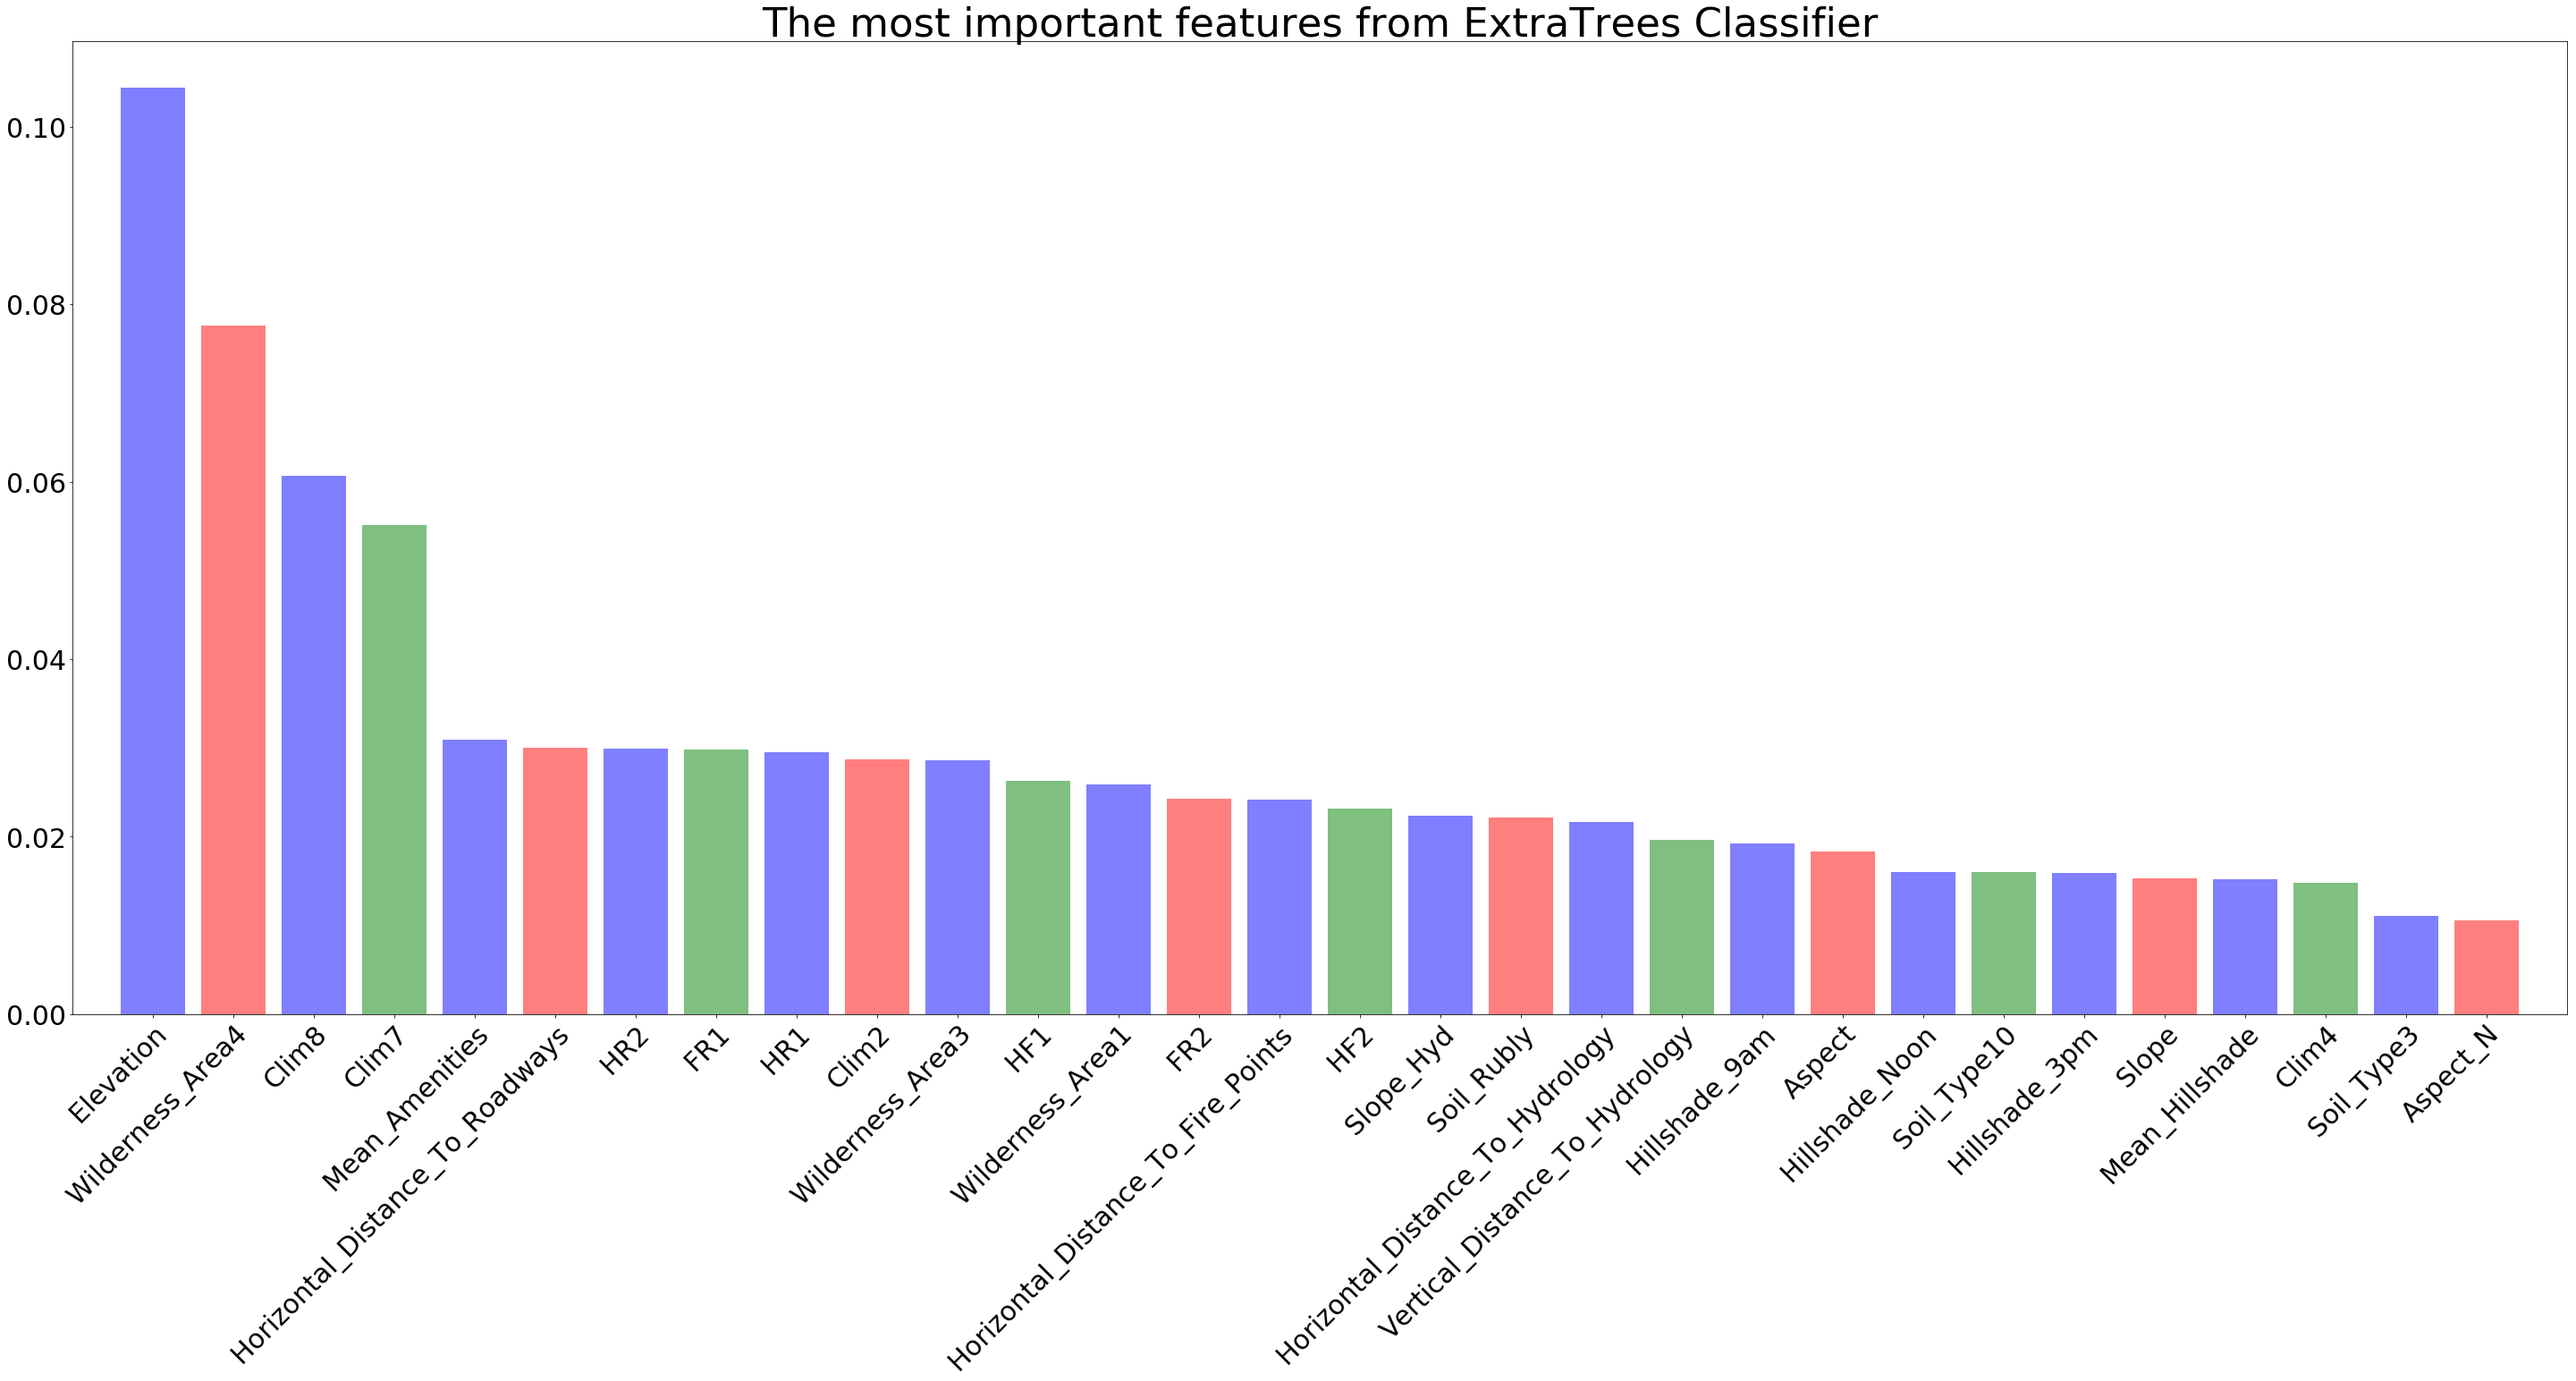

In [36]:
#Find Feature importance
etc_final = ExtraTreesClassifier(n_estimators=grid_etc.best_params_['n_estimators'],
                            criterion=grid_etc.best_params_['criterion'],random_state=0)
etc_final.fit(X_train, y_train)
etc_acc = etc_final.score(X_val,y_val)
print("The accuracy score of the ExtraTreesClassifier: ",round(etc_acc,2))
importances = etc_final.feature_importances_
indices = np.argsort(importances)[::-1]
getImportance(etc_final,X_train.columns,"The most important features from ExtraTrees Classifier")


**Extract smaller featureset** : We will be using a threshold of 0.01 to fetch the important features only.

In [37]:
select_model = SelectFromModel(etc_final, threshold=0.01, prefit=True)
X_train_selected = select_model.transform(X_train)
X_val_selected = select_model.transform(X_val)
print("The shape of the selected training dataset " ,X_train_selected.shape)
print("The shape of the selected validation dataset " ,X_val_selected.shape )

feature_index_etc = select_model.get_support()



The shape of the selected training dataset  (11962, 31)
The shape of the selected validation dataset  (3024, 31)


**Re-Run ExtraTreesClassifier with the selected features only**

In [38]:
# Build a forest with the important features only
grid_etc_selected = RandomizedSearchCV(forest, param_grid, cv=5, scoring="accuracy" ,return_train_score=False)
grid_etc_selected.fit(X_train_selected, y_train)
print("The best score: ",grid_etc_selected.best_score_.round(4))
#Parameter setting that gave the best results on the hold out data.
print("The best parameter: ",grid_etc_selected.best_params_)
grid_etc_selected.best_estimator_


The best score:  0.8758
The best parameter:  {'n_estimators': 165, 'criterion': 'entropy'}


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=165, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [39]:
#Find Feature importance
etc_selected = ExtraTreesClassifier(n_estimators=grid_etc_selected.best_params_['n_estimators'],
                            criterion=grid_etc_selected.best_params_['criterion'],random_state=0)
etc_selected.fit(X_train_selected, y_train)
etc_sel_acc = etc_selected.score(X_val_selected,y_val)
print("The accuracy score of the ExtraTreesClassifier with the selected features: ",round(etc_sel_acc,2))

The accuracy score of the ExtraTreesClassifier with the selected features:  0.88


>As seen above, the accuracy of the model did not decrease after reducing the feature set to 31. That means the rest of the data was not explaining any variance in the model or influencing the outcome.

### 2. Feature Selection with L1 Regularization
We now do a Logistic Regression with L1 regularization, discarding the zero coefficient features.  We then run a L2 Logistic Regression to validate the remaining feature selections.

In [40]:
#Run Logistic Regression with engineered features provided & L1 Regularization
logreg_l1 = LogisticRegression(penalty = 'l1',solver='saga', multi_class='multinomial',max_iter=500)
logreg_l1.fit(X_train, y_train)
y_pred_l1 = logreg_l1.predict(X_val)
print("Accuracy with L1 regularization and Engineered Data",metrics.accuracy_score(y_val,y_pred_l1)) 

model = SelectFromModel(logreg_l1, threshold=1.25, prefit=True)
X_train_l1_selected = model.transform(X_train)
X_val_l1_selected = model.transform(X_val)
print("The shape of the selected training dataset " ,X_train_l1_selected.shape)
print("The shape of the selected validation dataset " ,X_val_l1_selected.shape )

logreg_l1 = LogisticRegression(penalty = 'l2',solver='saga', multi_class='multinomial',max_iter=500)
logreg_l1.fit(X_train_l1_selected, y_train)
y_pred_l1 = logreg_l1.predict(X_val_l1_selected)
print("Accuracy with L2 regularization and Selected and Engineered Data",metrics.accuracy_score(y_val,y_pred_l1)) 

Accuracy with L1 regularization and Engineered Data 0.6888227513227513
The shape of the selected training dataset  (11962, 31)
The shape of the selected validation dataset  (3024, 31)
Accuracy with L2 regularization and Selected and Engineered Data 0.6865079365079365


>Given there is a minimal loss of accuracy only with the selected feature set, we will go ahead with the subset of features. We will merge the features found from L1-regularization with those from ExtraTreesclassification and create a union set of features.

In [41]:
#Combining selected features from Extra Trees classifier and L1 Regularization
feature_index_l1 = model.get_support()
#The below boolean array provides which features should be included in the dataset
final_feature = np.logical_or(feature_index_etc,feature_index_l1)
print("Total number of selected features from Extra Trees Classifier and Logistic Regression:", np.sum(final_feature))

common_feature = np.logical_and(feature_index_etc,feature_index_l1)
print("Total number of common features between Extra Trees Classifier and Logistic Regression:", np.sum(common_feature))
#print(final_feature)

#Getting the column indices for the selected features
column_list = np.where(final_feature)[0].tolist()
print(column_list)
X_train.columns[column_list]

Total number of selected features from Extra Trees Classifier and Logistic Regression: 46
Total number of common features between Extra Trees Classifier and Logistic Regression: 16
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 22, 23, 24, 25, 27, 28, 31, 34, 35, 40, 41, 43, 44, 52, 54, 57, 58, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 78]


In [42]:
#Creating training and validation dataset with the selected features from Extra Trees Classifier and L1 Regularization
X_train_final_selected = X_train.iloc[:,column_list].copy()
X_val_final_selected = X_val.iloc[:,column_list].copy()

print("Size of the final Training Dataset", X_train_final_selected.shape)
print("Size of the final validation Dataset", X_val_final_selected.shape)

Size of the final Training Dataset (11962, 46)
Size of the final validation Dataset (3024, 46)


### 3. Re-run models again with combined selected features
 - Run ExtraTreesClassifier for the Bagging
 - Run AdaBoost Classifier for Boosting
 - Run L2 Logistic Regression
 - Neural Net
 

**Bagging - ExtraTreesClassifier with combined selected features**

In [43]:
etc_selected = ExtraTreesClassifier(n_estimators=grid_etc.best_params_['n_estimators'],
                            criterion=grid_etc.best_params_['criterion'],random_state=0)
etc_selected.fit(X_train_final_selected, y_train)
etc_acc_sel = etc_selected.score(X_val_final_selected,y_val)
print("The accuracy score of the ExtraTreesClassifier with combined selected feature : ",round(etc_acc_sel,2))


The accuracy score of the ExtraTreesClassifier with combined selected feature :  0.88


In [44]:
y_predict_etc = etc_selected.predict(X_val_final_selected)
metrics.confusion_matrix(y_val,y_predict_etc)

array([[340,  63,   1,   0,   7,   1,  20],
       [ 70, 300,  11,   0,  29,  18,   4],
       [  0,   2, 373,  17,   5,  35,   0],
       [  0,   0,   8, 422,   0,   2,   0],
       [  0,   9,   9,   0, 412,   2,   0],
       [  0,   2,  32,   7,   3, 388,   0],
       [ 11,   0,   0,   0,   0,   0, 421]], dtype=int64)

**Boosting - AdaBoost with combined selected features**

In [45]:
# define the parameter values that should be searched
n_estimators = list(range(50,650,10))
learning_rate=list([1,1.5,2.0])
base_estimator= list([DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4)])
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=n_estimators,learning_rate=learning_rate)
#param_grid = dict(base_estimator=base_estimator,n_estimators=n_estimators)
# instantiate and fit the grid
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6),algorithm='SAMME')
grid_ada = RandomizedSearchCV(ada, param_grid, cv=3, scoring='accuracy' ,return_train_score=False)
grid_ada.fit(X_train_final_selected, y_train)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640], 'learning_rate': [1, 1.5, 2.0]},
     

In [46]:
#Estimator that was chosen by the search, i.e. estimator which gave highest score 
grid_ada.best_estimator_

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=620, random_state=None)

In [47]:
#Mean cross-validated score of the best_estimator
print("The best score: ",grid_ada.best_score_.round(4))
#Parameter setting that gave the best results on the hold out data.
print("The best parameter: ",grid_ada.best_params_)

The best score:  0.8243
The best parameter:  {'n_estimators': 620, 'learning_rate': 1}


In [48]:
ada_final = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                            learning_rate=grid_ada.best_params_['learning_rate'],
                         n_estimators=grid_ada.best_params_['n_estimators'])
#ada_final = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6), n_estimators=600, learning_rate=1)
ada_final.fit(X_train_final_selected,y_train)
ada_acc_sel =ada_final.score(X_val_final_selected,y_val)
print("The accuracy score of the AdaBoostClassifier with combined selected feature : ",round(ada_acc_sel,2))


The accuracy score of the AdaBoostClassifier with combined selected feature :  0.77


### **Logistic Regression with combined selected features**

0.7017195767195767

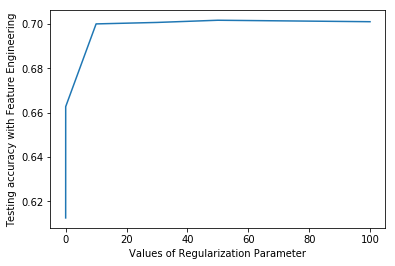

In [49]:
#Run Logistic Regression with only the Original data provided & L2 Regularization
C_range=[1e-3,1e-2,10,20,30,50,100]
scores_logreg2=[]
for c in C_range:
    logreg2 = LogisticRegression(C=c, solver='lbfgs', multi_class='multinomial',max_iter=300)
    logreg2.fit(X_train_final_selected, y_train)
    y_pred2 = logreg2.predict(X_val_final_selected)
    scores_logreg2.append(metrics.accuracy_score(y_val,y_pred2))

    
#Plot Logistic Regression with only the Original data provided
plt.plot(C_range,scores_logreg2)
plt.xlabel("Values of Regularization Parameter")
plt.ylabel("Testing accuracy with Feature Engineering")
max(scores_logreg2)

In [50]:
#Run Logistic Regression with feature engineering data provided & L1 Regularization
logreg2_l1 = LogisticRegression(penalty = 'l1',solver='saga', multi_class='multinomial',max_iter=500)
logreg2_l1.fit(X_train_final_selected, y_train)
y_pred2_l1 = logreg2_l1.predict(X_val_final_selected)
print("Accuracy with L2 regularization and Feature Engineered Data",metrics.accuracy_score(y_val,y_pred2_l1))

Accuracy with L2 regularization and Feature Engineered Data 0.6970899470899471


#### Neural Nets with combined selected features

In [51]:
# Starting with a 2 layer nn, with various setting of batch size and epochs

batch_parms = [5,10]
epoch_parms = [50,75,100]

for batch_p in batch_parms:
    for epoch_p in epoch_parms:
        model = Sequential()
        model.add(Dense(25, input_dim=46, activation='relu'))
        model.add(Dense(7, input_dim=25, activation='softmax'))
        ## Cost function & Objective (and solver)
        sgd = optimizers.SGD(lr=0.01)
        model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
        # using the binazied labels created earlier in the notebook
        history = model.fit(X_train_final_selected, y_train_orig_b, shuffle=True, batch_size=batch_p,verbose=0, epochs=epoch_p) 
        score = model.evaluate(X_val_final_selected, y_val_orig_b, verbose=0) 
        print("For combined selected features with 2 layer NN with batch size %d and epoch size %d, the loss is %7.4f and the accuracy is %7.4f" % (batch_p, epoch_p, score[0], score[1]))

For combined selected features with 2 layer NN with batch size 5 and epoch size 50, the loss is  0.5633 and the accuracy is  0.7755
For combined selected features with 2 layer NN with batch size 5 and epoch size 75, the loss is  0.5547 and the accuracy is  0.7768
For combined selected features with 2 layer NN with batch size 5 and epoch size 100, the loss is  0.5762 and the accuracy is  0.7758
For combined selected features with 2 layer NN with batch size 10 and epoch size 50, the loss is  0.5833 and the accuracy is  0.7632
For combined selected features with 2 layer NN with batch size 10 and epoch size 75, the loss is  0.5792 and the accuracy is  0.7533
For combined selected features with 2 layer NN with batch size 10 and epoch size 100, the loss is  0.5570 and the accuracy is  0.7738


In [52]:
# Next, let's try a 4 layer nn, with various setting of batch size and epochs

batch_parms = [5,10]
epoch_parms = [50,75,100]

for batch_p in batch_parms:
    for epoch_p in epoch_parms:
        model = Sequential()
        model.add(Dense(30, input_dim=46, activation='relu'))
        model.add(Dense(35, input_dim=30, activation='relu'))
        model.add(Dense(20, input_dim=35, activation='relu'))
        model.add(Dense(7, input_dim=20, activation='softmax'))
        ## Cost function & Objective (and solver)
        sgd = optimizers.SGD(lr=0.01)
        model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
        # using the binazied labels created earlier in the notebook
        history = model.fit(X_train_final_selected, y_train_orig_b, shuffle=True, batch_size=batch_p,verbose=0, epochs=epoch_p) 
        score = model.evaluate(X_val_final_selected, y_val_orig_b, verbose=0) 
        print("For combined selected features with 4 layer NN with batch size %d and epoch size %d, the loss is %7.4f and the accuracy is %7.4f" % (batch_p, epoch_p, score[0], score[1]))

For combined selected features with 4 layer NN with batch size 5 and epoch size 50, the loss is  0.6647 and the accuracy is  0.7679
For combined selected features with 4 layer NN with batch size 5 and epoch size 75, the loss is  0.5214 and the accuracy is  0.8128
For combined selected features with 4 layer NN with batch size 5 and epoch size 100, the loss is  0.7707 and the accuracy is  0.7533
For combined selected features with 4 layer NN with batch size 10 and epoch size 50, the loss is  0.7104 and the accuracy is  0.7503
For combined selected features with 4 layer NN with batch size 10 and epoch size 75, the loss is  0.5127 and the accuracy is  0.8108
For combined selected features with 4 layer NN with batch size 10 and epoch size 100, the loss is  0.5201 and the accuracy is  0.8022


>**Observation from running models with combined selected features**
1. There isn't much change in accuracy of the ExtraTreesClassifier Model with feature engineered data. 
2. There isn't much change in accuracy of the AdaBoost Model with feature engineered data. 
3. There isn't much change in accuracy of the Logistic Regression Model with feature engineered data.
4. The accuracy of the neural net model with the feature engineered data and using the same hyper parameters as with the baseline model was approximately equal.  However adjusting the hyper parameters of the neural net to use more hidden layers and more epochs did increase the accuracy of the nernal net model with the feature engineered data.  We did not test the baseline data with the neural net models with varying hyper parameter settings.

## Ensembling models run on feature engineered and reduced dataset

In [53]:
def make_nn_classifier():
    model = Sequential()
    model.add(Dense(30, input_dim=46, activation='relu'))
    model.add(Dense(35, input_dim=30, activation='relu'))
    model.add(Dense(20, input_dim=35, activation='relu'))
    model.add(Dense(7, input_dim=20, activation='softmax'))
    ## Cost function & Objective (and solver)
    sgd = optimizers.SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [54]:
#Ensembling Neural net,Adaboost, Logistic Regression and Extra Trees Classifier

logreg_ensemble = LogisticRegression(C=100, solver='lbfgs', multi_class='multinomial',max_iter=300)
etc_ensemble = ExtraTreesClassifier(n_estimators=grid_etc.best_params_['n_estimators'],
                            criterion=grid_etc.best_params_['criterion'],random_state=0)
nn_ensemble = KerasClassifier(build_fn = make_nn_classifier,
                            batch_size=10, nb_epoch=100)
ada_ensemble = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                            learning_rate=grid_ada.best_params_['learning_rate'],
                             n_estimators=grid_ada.best_params_['n_estimators'])
voting_ensemble = VotingClassifier(estimators=[('lr', logreg_ensemble), ('etc', etc_ensemble),('nn', nn_ensemble),
                                              ('ada', ada_ensemble)],voting='hard')

voting_ensemble.fit(X_train_final_selected, y_train)
y_pred_ensemble = voting_ensemble.predict(X_val_final_selected)
print("Accuracy achieved by ensembling",metrics.accuracy_score(y_val,y_pred_ensemble))

Epoch 1/1
11962/11962 [==============================] - 2s 145us/step - loss: 1.2699 - acc: 0.4896
Accuracy achieved by ensembling 0.8012566137566137


## Run PCA to do dimensionality reduction on data set with combined features from feature selection
<img src="images/FlowDiagramForest3.png" alt="Feature Selection" style="height: 400px;width: 450px;"/>

In [55]:
# Run PCA to determine the number of principal components to use

pca_mod = PCA()
pca_mod.fit(X_train_final_selected)
num_features_selected = X_train_final_selected.shape[1]
print("Number of features in combined, feature-reduced data sets = %d" % num_features_selected)
var_arr=np.zeros((num_features_selected))
cum_var_arr=np.zeros((num_features_selected))
cum_var=0.0

for n_comp in range(1,num_features_selected + 1):
    cum_var = cum_var + pca_mod.explained_variance_ratio_[n_comp - 1]
    var_arr[n_comp - 1] = round(pca_mod.explained_variance_ratio_[n_comp - 1],2)
    cum_var_arr[n_comp - 1] = round(cum_var,3)

var_rslts = pd.DataFrame({'Principal Component':range(1,num_features_selected + 1),'Variance Explained':var_arr,'Cumulative Variance Explained':cum_var_arr})


Number of features in combined, feature-reduced data sets = 46


,Variance Explained,Cumulative Variance Explained
Principal Component,,
1,0.31,0.313
2,0.12,0.432
3,0.10,0.535
4,0.10,0.631
5,0.07,0.697
6,0.06,0.754
7,0.05,0.801
8,0.04,0.845
9,0.03,0.877


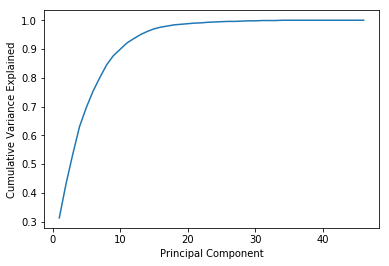

In [56]:
#Plot cumulative variance explained
plt.plot(var_rslts['Principal Component'],var_rslts['Cumulative Variance Explained'])
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained")

var_rslts.set_index('Principal Component',inplace=True)

var_rslts

Looks Like most variance (99.5%) is explained once we reach 26 principal components, so let's create training and validation data sets using the first 26 principal components

In [57]:
pca_mod = PCA(n_components=26)
dimr_X_train_final_selected = pca_mod.fit_transform(X_train_final_selected)
dimr_X_val_final_selected = pca_mod.transform(X_val_final_selected)

print("Size of the dimensionality reduced training dataset", dimr_X_train_final_selected.shape)
print("Size of the dimensionality reduced validation dataset", dimr_X_val_final_selected.shape)

Size of the dimensionality reduced training dataset (11962, 26)
Size of the dimensionality reduced validation dataset (3024, 26)


### Neural Nets using Dimensionality Reduced Datasets

In [58]:
# Let's try a 2 layer nn, with various setting of batch size and epochs

batch_parms = [5,10]
epoch_parms = [50,75,100]

for batch_p in batch_parms:
    for epoch_p in epoch_parms:
        model = Sequential()
        model.add(Dense(15, input_dim=26, activation='relu'))
        model.add(Dense(7, input_dim=15, activation='softmax'))
        ## Cost function & Objective (and solver)
        sgd = optimizers.SGD(lr=0.01)
        model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
        # using the binazied labels created earlier in the notebook
        history = model.fit(dimr_X_train_final_selected, y_train_orig_b, shuffle=True, batch_size=batch_p,verbose=0, epochs=epoch_p) 
        score = model.evaluate(dimr_X_val_final_selected, y_val_orig_b, verbose=0) 
        print("For 2 layer NN with batch size %d and epoch size %d, the loss is %7.4f and the accuracy is %7.4f" % (batch_p, epoch_p, score[0], score[1]))

For 2 layer NN with batch size 5 and epoch size 50, the loss is  0.6185 and the accuracy is  0.7464
For 2 layer NN with batch size 5 and epoch size 75, the loss is  0.5993 and the accuracy is  0.7566
For 2 layer NN with batch size 5 and epoch size 100, the loss is  0.6049 and the accuracy is  0.7470
For 2 layer NN with batch size 10 and epoch size 50, the loss is  0.6219 and the accuracy is  0.7374
For 2 layer NN with batch size 10 and epoch size 75, the loss is  0.6096 and the accuracy is  0.7470
For 2 layer NN with batch size 10 and epoch size 100, the loss is  0.5993 and the accuracy is  0.7639


In [59]:
# Next, let's try a 4 layer nn, with various setting of batch size and epochs

batch_parms = [5,10]
epoch_parms = [50,75,100]

for batch_p in batch_parms:
    for epoch_p in epoch_parms:
        model = Sequential()
        model.add(Dense(20, input_dim=26, activation='relu'))
        model.add(Dense(30, input_dim=20, activation='relu'))
        model.add(Dense(15, input_dim=30, activation='relu'))
        model.add(Dense(7, input_dim=15, activation='softmax'))
        ## Cost function & Objective (and solver)
        sgd = optimizers.SGD(lr=0.01)
        model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
        # using the binazied labels created earlier in the notebook
        history = model.fit(dimr_X_train_final_selected, y_train_orig_b, shuffle=True, batch_size=batch_p,verbose=0, epochs=epoch_p) 
        score = model.evaluate(dimr_X_val_final_selected, y_val_orig_b, verbose=0) 
        print("For 4 layer NN with batch size %d and epoch size %d, the loss is %7.4f and the accuracy is %7.4f" % (batch_p, epoch_p, score[0], score[1]))

For 4 layer NN with batch size 5 and epoch size 50, the loss is  0.5704 and the accuracy is  0.7761
For 4 layer NN with batch size 5 and epoch size 75, the loss is  0.5251 and the accuracy is  0.8085
For 4 layer NN with batch size 5 and epoch size 100, the loss is  0.5798 and the accuracy is  0.7900
For 4 layer NN with batch size 10 and epoch size 50, the loss is  0.6216 and the accuracy is  0.7596
For 4 layer NN with batch size 10 and epoch size 75, the loss is  0.5402 and the accuracy is  0.7953
For 4 layer NN with batch size 10 and epoch size 100, the loss is  0.5986 and the accuracy is  0.7923


In [60]:
# It looks like the 4 layer NN with a batch size of 5 and 100 epochs is giving us the best accuracy. 
# So let's refit a model with those hyper parameters and create a confusion matrix to see which
# classes the model is doing well with and which have higher error rates

model = Sequential()
model.add(Dense(20, input_dim=26, activation='relu'))
model.add(Dense(30, input_dim=20, activation='relu'))
model.add(Dense(15, input_dim=30, activation='relu'))
model.add(Dense(7, input_dim=15, activation='softmax'))
## Cost function & Objective (and solver)
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# using the binazied labels created earlier in the notebook
history = model.fit(dimr_X_train_final_selected, y_train_orig_b, shuffle=True, batch_size=5,verbose=0, epochs=100) 
score = model.evaluate(dimr_X_val_final_selected, y_val_orig_b, verbose=0) 
print("For 4 layer NN with batch size 5 and epoch size 10, the loss is %7.4f and the accuracy is %7.4f" % (score[0], score[1]))
print("\n")

# predict classes
nn_preds =  model.predict_classes(dimr_X_val_final_selected)
nn_preds = nn_preds + 1 # adding one back to compensate for 1 - 7 labels converted to 0 - 6 index in binarizing function
nn_preds.shape

# generate confusion matrix
metrics.confusion_matrix(y_val_orig,nn_preds)


For 4 layer NN with batch size 5 and epoch size 10, the loss is  0.5471 and the accuracy is  0.7983




array([[282,  99,   2,   0,  12,   2,  35],
       [ 78, 267,  15,   0,  43,  26,   3],
       [  0,   6, 331,  34,   9,  52,   0],
       [  0,   0,   8, 424,   0,   0,   0],
       [  0,  27,   9,   0, 390,   6,   0],
       [  0,   4,  85,  30,   3, 310,   0],
       [ 21,   1,   0,   0,   0,   0, 410]], dtype=int64)

### RandomForest using Dimensionality Reduced Datasets

In [61]:
n_estimators = list(range(50, 250,5))
criterion=['gini','entropy']
# create a parameter grid: map the parameter names to the values that should be searched
param_grid_rf = dict(n_estimators=n_estimators,criterion=criterion)

# instantiate and fit the grid
rf = RandomForestClassifier()
grid_rf = RandomizedSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy' ,return_train_score=False)

grid_rf.fit(dimr_X_train_final_selected, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=False, scoring='accuracy', verbose=0)

In [62]:
#Mean cross-validated score of the best_estimator
print("The best score: ",grid_rf.best_score_.round(4))
#Parameter setting that gave the best results on the hold out data.
print("The best parameter: ",grid_rf.best_params_)


The best score:  0.8461
The best parameter:  {'n_estimators': 160, 'criterion': 'entropy'}


In [63]:
rf_final = RandomForestClassifier(criterion=grid_rf.best_params_['criterion'],
                            n_estimators=grid_rf.best_params_['n_estimators'])
rf_final.fit(dimr_X_train_final_selected,y_train)
rf_score=rf_final.score(dimr_X_val_final_selected,y_val)

print("The accuracy score of the RandomForest with reduced feature set: ",round(rf_score,2))


The accuracy score of the RandomForest with reduced feature set:  0.85


<module 'matplotlib.pyplot' from 'C:\\Users\\jbraun\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

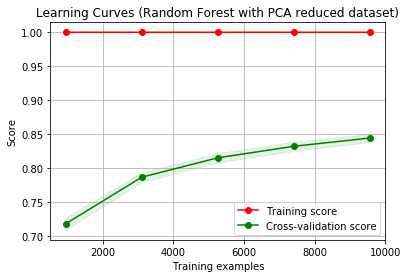

In [64]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
title = "Learning Curves (Random Forest with PCA reduced dataset)"
plot_learning_curve(rf_final, title, dimr_X_train_final_selected, y_train, ylim=None, cv=cv,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

The learning curve above demonstrates the insufficiency of the size of the training set. 

### AdaBoost using Dimensionality Reduced Datasets

In [65]:
# define the parameter values that should be searched
n_estimators = list(range(50,650,10))
learning_rate=list([1,1.5,2.0])
base_estimator= list([DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4)])
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=n_estimators,learning_rate=learning_rate)
#param_grid = dict(base_estimator=base_estimator,n_estimators=n_estimators)
# instantiate and fit the grid
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6),algorithm='SAMME')
grid_ada_reduced = RandomizedSearchCV(ada, param_grid, cv=3, scoring='accuracy' ,return_train_score=False)
grid_ada_reduced.fit(dimr_X_train_final_selected, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640], 'learning_rate': [1, 1.5, 2.0]},
     

In [66]:
#Estimator that was chosen by the search, i.e. estimator which gave highest score 
grid_ada_reduced.best_estimator_

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.5, n_estimators=620, random_state=None)

In [67]:
#Mean cross-validated score of the best_estimator
print("The best score: ",grid_ada_reduced.best_score_.round(4))
#Parameter setting that gave the best results on the hold out data.
print("The best parameter: ",grid_ada_reduced.best_params_)

The best score:  0.7953
The best parameter:  {'n_estimators': 620, 'learning_rate': 1.5}


In [68]:
ada_final_reduced = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                            learning_rate=grid_ada_reduced.best_params_['learning_rate'],
                         n_estimators=grid_ada_reduced.best_params_['n_estimators'])
#ada_final = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6), n_estimators=600, learning_rate=1)
ada_final_reduced.fit(dimr_X_train_final_selected,y_train)
ada_acc_sel =ada_final_reduced.score(dimr_X_val_final_selected,y_val)
print("The accuracy score of the AdaBoostClassifier with reduced feature set: ",round(ada_acc_sel,2))


The accuracy score of the AdaBoostClassifier with reduced feature set:  0.76


### Logistic Regression with Dimensionality Reduced Datasets

0.6841931216931217

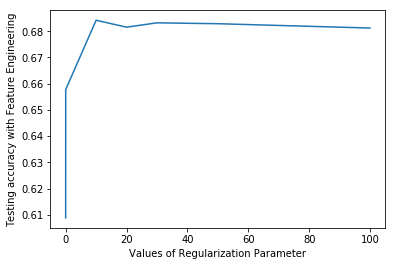

In [69]:
#Run Logistic Regression with only the Original data provided & L2 Regularization
C_range=[1e-3,1e-2,10,20,30,50,100]
scores_logreg3=[]
for c in C_range:
    logreg3 = LogisticRegression(C=c, solver='lbfgs', multi_class='multinomial',max_iter=300)
    logreg3.fit(dimr_X_train_final_selected, y_train)
    y_pred3 = logreg3.predict(dimr_X_val_final_selected)
    scores_logreg3.append(metrics.accuracy_score(y_val,y_pred3))

    
#Plot Logistic Regression with only the Original data provided
plt.plot(C_range,scores_logreg3)
plt.xlabel("Values of Regularization Parameter")
plt.ylabel("Testing accuracy with Feature Engineering")
max(scores_logreg3)

In [70]:
#Run Logistic Regression with feature engineering data provided & L1 Regularization
logreg3_l1 = LogisticRegression(solver='saga', multi_class='multinomial',max_iter=500)
logreg3_l1.fit(dimr_X_train_final_selected, y_train)
y_pred3_l1 = logreg3_l1.predict(dimr_X_val_final_selected)
print("Accuracy with L2 regularization and Feature Engineered and Reduced Data",metrics.accuracy_score(y_val,y_pred3_l1))

Accuracy with L2 regularization and Feature Engineered and Reduced Data 0.6884920634920635


<module 'matplotlib.pyplot' from 'C:\\Users\\jbraun\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

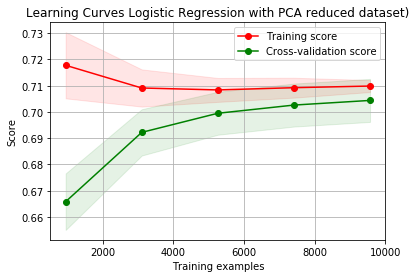

In [71]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
title = "Learning Curves Logistic Regression with PCA reduced dataset)"
plot_learning_curve(logreg3_l1, title, dimr_X_train_final_selected, y_train, ylim=None, cv=cv,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

## Ensemble

In [72]:
def make_nn_red_classifier():
    model = Sequential()
    model.add(Dense(20, input_dim=26, activation='relu'))
    model.add(Dense(30, input_dim=20, activation='relu'))
    model.add(Dense(15, input_dim=30, activation='relu'))
    model.add(Dense(7, input_dim=15, activation='softmax'))
    ## Cost function & Objective (and solver)
    sgd = optimizers.SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [73]:
#Ensembling Neural net,Adaboost, Logistic Regression and Extra Trees Classifier

logreg_ensemble = LogisticRegression(C=100, solver='lbfgs', multi_class='multinomial',max_iter=300)
rf_red_ensemble = RandomForestClassifier(criterion=grid_rf.best_params_['criterion'],
                            n_estimators=grid_rf.best_params_['n_estimators'])

nn_red_ensemble = KerasClassifier(build_fn = make_nn_red_classifier,
                            batch_size=5, nb_epoch=100)
ada_red_ensemble = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                            learning_rate=grid_ada_reduced.best_params_['learning_rate'],
                         n_estimators=grid_ada_reduced.best_params_['n_estimators'])

voting_ensemble = VotingClassifier(estimators=[('lr', logreg_ensemble), ('rf', rf_red_ensemble),('nn', nn_red_ensemble),
                                              ('ada', ada_red_ensemble)],voting='hard')

voting_ensemble.fit(dimr_X_train_final_selected, y_train)
y_pred_ensemble = voting_ensemble.predict(dimr_X_val_final_selected)
print("Accuracy achieved by ensembling",metrics.accuracy_score(y_val,y_pred_ensemble))

Epoch 1/1
11962/11962 [==============================] - 3s 261us/step - loss: 1.1677 - acc: 0.5321
Accuracy achieved by ensembling 0.7787698412698413


Overall, the accuracy of the various models  of the various models decreased slightly with the dimensionality-reduced data sets.

## Conclusion

Observations that emerged from our testing are as follows:

Some of the engineered features that we created were selected by ExtraTrees classification and L1 regularization as useful features to use in additiona to or as replacements of the underlying base features from which they were created.  Time invested in feature engineering was worth it.

For this challenge, removing outliers did not prove to be useful in improving the performace of models.  Model performance did not vary significantly with or without outliers.

Differences in feature selection using Extra Trees Classifier and L1 Regularization -- We observed that the features selected by the extra trees classifier were significantly different from those selected by L1 regularization. The two subsets of features had only 16 common features while our superset of features from both selection approaches included 46 features (out of a total of 79 possible features).  This is likely due to the significanlty different approaches that each method uses to choose features, with trees classifiers comparing each feature one at a time to other features, and L1 regularization computing penalities for all features in each iteration.

Generalization proved to be very challenging.  While accuracy using the training and validation data was ~70-80%, the accuracy on the Kaggle test sets was ~40-50%.  This demonstrated overfitting and highlighted the non-represantative training data we had that was also small in size. 

Logistic Regression consistently underperformed compared to other classifiers. This may be because Logistic Regression is a linear model and is not expected to perform well when classes are highly correlated or highly nonlinear.  Also, it is a single layer gradient descent classifier.  As seen in the neural net testing, more layers tend to improve the predictive power of our models.

### Lessons Learned and Additional Modelling

To address the small size of our training data and the overfitting we observed, we would probably want to try multiple training/validation data split techniques.  Also, we should leverage cross-validation techniques that perform a variety of training/dev data splits on the training data during model training for any models that do not incorporate cross-validation data splitting techniques by default.

Accuracy improvements appear to be available with neural nets by conducting several more tests with increased numbers of layers and varying epochs and other hyper parameters.  Including the improved neural nets with the best performing of the other models (e.g., ExtraTrees) in an ensemble model should improve overall accuracy.  Also, testing with different ways to weight the votes of models in the ensemble based upon the classes that they predict most accurately should also improve overall performance.

Time did not allow us to test our various models with just the limited features selected by ExtraTrees and just those selected by L1 regularization.  It would be interesting to run those tests to see if using just those limited features sets improved overll accuracy.